# 성별 분석 

## import files

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
import hanja
from krwordrank.hangle import normalize
%matplotlib inline

In [2]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [9]:
gender_total = pd.read_csv('whole-gender-bill-1320.csv', index_col=0, encoding='utf-8-sig')
print(gender_total.shape)
gender_total.head(1)

(4295, 16)


의안번호         의안명        제안일자 제안자구분        의결일자  의결결과  \
0  131131  소득세법중개정법률안  1990-12-17   위원장  1990-12-18  원안가결   

                     제안회기                                               제안이유  \
0  제13대 (1988~1992) 제151회     정부제출,柳인학·강金식·금봉욱·林춘원·李경재·허만기·홍영기의원외64인 발의,1...   

   소관위원회 제안자  발의자 제안정당   성별  여성의원 수 정당성향  국회회기  
0  재무위원회  []  위원장  위원장  NaN       0  NaN    13

## 1. 성별 분석

In [150]:
gender = gender_total[gender_total['제안자구분'] == '의원']

In [11]:
gender['성별'].value_counts()

남성    2145
여성    1621
Name: 성별, dtype: int64

In [12]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명','보장하',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자',
            '조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출']

    text = [word for word in text if word not in stopwords]
    return text

In [13]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [14]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 220 ms, sys: 4 ms, total: 224 ms
Wall time: 225 ms


In [15]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [16]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 2min 6s, sys: 1.04 s, total: 2min 7s
Wall time: 1min 52s


2    [유아의보호, 교육에관한법률안, 현대사회, 산업화, 여성, 사회참여, 가족구조, 핵...
3    [특정강력범죄의처벌에관한특례법안, 반인륜, 반사회적, 흉악범죄, 가정, 사회질서, ...
6    [지방선거법안, 지방의회의원, 지방자치단체, 주민, 선출, 지방자치, 이념, 구현,...
Name: tokens, dtype: object

In [17]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 1.11 s, sys: 5.53 ms, total: 1.12 s
Wall time: 1.15 s


In [18]:
%time gender['명사수'] = gender['tokens'].apply(len)

CPU times: user 1.76 ms, sys: 71 µs, total: 1.83 ms
Wall time: 1.78 ms


In [34]:
# 명사 수가 10개를 넘어가는 경우만 추출
gender = gender[gender['명사수'] >= 10]
gender = gender.reset_index(drop=True)
print(gender.shape)

(3756, 20)


In [50]:
gender[gender['tokens'] == np.nan]

Empty DataFrame
Columns: [의안번호, 의안명, 제안일자, 제안자구분, 의결일자, 의결결과, 제안회기, 제안이유, 소관위원회, 제안자, 발의자, 제안정당, 성별, 여성의원 수, 정당성향, 국회회기, 의안텍스트, tokens, 명사수, 문장벡터]
Index: []

### 여성/남성 나누기

In [51]:
women = gender[gender['성별'] == '여성']
men = gender[gender['성별'] == '남성']

In [52]:
print(women.shape)
print(men.shape)

(1618, 20)
(2138, 20)


In [53]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [54]:
model_women = Word2Vec(women['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=0)
model_men = Word2Vec(men['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=0)

2020-10-10 23:19:36,827 : INFO : collecting all words and their counts
2020-10-10 23:19:36,829 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-10 23:19:36,857 : INFO : collected 14099 word types from a corpus of 125280 raw words and 1618 sentences
2020-10-10 23:19:36,858 : INFO : Loading a fresh vocabulary
2020-10-10 23:19:36,868 : INFO : effective_min_count=10 retains 2024 unique words (14% of original 14099, drops 12075)
2020-10-10 23:19:36,869 : INFO : effective_min_count=10 leaves 98159 word corpus (78% of original 125280, drops 27121)
2020-10-10 23:19:36,875 : INFO : deleting the raw counts dictionary of 14099 items
2020-10-10 23:19:36,877 : INFO : sample=0.001 downsamples 43 most-common words
2020-10-10 23:19:36,877 : INFO : downsampling leaves estimated 88095 word corpus (89.7% of prior 98159)
2020-10-10 23:19:36,884 : INFO : estimated required memory for 2024 words and 100 dimensions: 2631200 bytes
2020-10-10 23:19:36,887 : INFO : resetting la

2020-10-10 23:19:38,878 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:38,880 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:38,882 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:38,888 : INFO : EPOCH - 15 : training on 125280 raw words (88169 effective words) took 0.1s, 873174 effective words/s
2020-10-10 23:19:38,980 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:38,993 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:38,998 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:38,999 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:39,000 : INFO : EPOCH - 16 : training on 125280 raw words (88057 effective words) took 0.1s, 842162 effective words/s
2020-10-10 23:19:39,079 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-10-10 23:19:40,302 : INFO : EPOCH - 31 : training on 125280 raw words (88109 effective words) took 0.1s, 1068675 effective words/s
2020-10-10 23:19:40,381 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:40,383 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:40,384 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:40,385 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:40,386 : INFO : EPOCH - 32 : training on 125280 raw words (88138 effective words) took 0.1s, 1093784 effective words/s
2020-10-10 23:19:40,464 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:40,465 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:40,469 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:40,472 : INFO : worker thread finished; awaiting finish of 0 more threads


2020-10-10 23:19:41,722 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:41,723 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:41,724 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:41,726 : INFO : EPOCH - 48 : training on 125280 raw words (88134 effective words) took 0.1s, 1086390 effective words/s
2020-10-10 23:19:41,806 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:41,814 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:41,816 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:41,817 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:41,819 : INFO : EPOCH - 49 : training on 125280 raw words (88010 effective words) took 0.1s, 992907 effective words/s
2020-10-10 23:19:41,906 : INFO : worker thread finished; awaiting finish of 3 more threads
2

2020-10-10 23:19:43,087 : INFO : EPOCH - 64 : training on 125280 raw words (88265 effective words) took 0.1s, 1252532 effective words/s
2020-10-10 23:19:43,163 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:43,166 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:43,169 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:43,171 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:43,172 : INFO : EPOCH - 65 : training on 125280 raw words (88006 effective words) took 0.1s, 1085694 effective words/s
2020-10-10 23:19:43,248 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:43,249 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:43,252 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:43,255 : INFO : worker thread finished; awaiting finish of 0 more threads


2020-10-10 23:19:44,497 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:44,504 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:44,508 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:44,509 : INFO : EPOCH - 81 : training on 125280 raw words (88102 effective words) took 0.1s, 987080 effective words/s
2020-10-10 23:19:44,588 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:44,595 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:44,596 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:44,603 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:44,603 : INFO : EPOCH - 82 : training on 125280 raw words (88193 effective words) took 0.1s, 980398 effective words/s
2020-10-10 23:19:44,673 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-10-10 23:19:45,855 : INFO : EPOCH - 97 : training on 125280 raw words (88044 effective words) took 0.1s, 1086910 effective words/s
2020-10-10 23:19:45,926 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:45,930 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:45,934 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:45,935 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:45,936 : INFO : EPOCH - 98 : training on 125280 raw words (88086 effective words) took 0.1s, 1240130 effective words/s
2020-10-10 23:19:46,001 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:46,005 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:46,007 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:46,009 : INFO : worker thread finished; awaiting finish of 0 more threads


2020-10-10 23:19:47,938 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:47,940 : INFO : EPOCH - 11 : training on 155475 raw words (112770 effective words) took 0.1s, 1209833 effective words/s
2020-10-10 23:19:48,025 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:48,029 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:48,033 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:48,034 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:48,035 : INFO : EPOCH - 12 : training on 155475 raw words (112839 effective words) took 0.1s, 1298523 effective words/s
2020-10-10 23:19:48,123 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:48,129 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:48,132 : INFO : worker thread finished; awaiting finish of 1 more thread

2020-10-10 23:19:49,667 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:49,671 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:49,674 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:49,676 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:49,676 : INFO : EPOCH - 28 : training on 155475 raw words (112797 effective words) took 0.1s, 1250121 effective words/s
2020-10-10 23:19:49,780 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:49,788 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:49,789 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:49,793 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:49,794 : INFO : EPOCH - 29 : training on 155475 raw words (112786 effective words) took 0.1s, 1026055 effective words/

2020-10-10 23:19:51,408 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:51,410 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:51,411 : INFO : EPOCH - 44 : training on 155475 raw words (112857 effective words) took 0.1s, 1225624 effective words/s
2020-10-10 23:19:51,501 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:51,506 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:51,510 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:51,511 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:51,512 : INFO : EPOCH - 45 : training on 155475 raw words (112634 effective words) took 0.1s, 1185735 effective words/s
2020-10-10 23:19:51,593 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:51,597 : INFO : worker thread finished; awaiting finish of 2 more thread

2020-10-10 23:19:53,113 : INFO : EPOCH - 60 : training on 155475 raw words (112690 effective words) took 0.1s, 1008075 effective words/s
2020-10-10 23:19:53,204 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:53,209 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:53,213 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:53,214 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:53,215 : INFO : EPOCH - 61 : training on 155475 raw words (112821 effective words) took 0.1s, 1173814 effective words/s
2020-10-10 23:19:53,306 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:53,311 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:53,314 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:53,315 : INFO : worker thread finished; awaiting finish of 0 more thread

2020-10-10 23:19:54,881 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:54,886 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:54,887 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:54,888 : INFO : EPOCH - 77 : training on 155475 raw words (112786 effective words) took 0.1s, 1132695 effective words/s
2020-10-10 23:19:54,991 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:54,994 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:55,000 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:55,004 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:55,005 : INFO : EPOCH - 78 : training on 155475 raw words (112701 effective words) took 0.1s, 1005631 effective words/s
2020-10-10 23:19:55,105 : INFO : worker thread finished; awaiting finish of 3 more thread

2020-10-10 23:19:56,585 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:56,586 : INFO : EPOCH - 93 : training on 155475 raw words (112869 effective words) took 0.1s, 1068980 effective words/s
2020-10-10 23:19:56,685 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:56,693 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:56,694 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 23:19:56,702 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 23:19:56,703 : INFO : EPOCH - 94 : training on 155475 raw words (112735 effective words) took 0.1s, 1017101 effective words/s
2020-10-10 23:19:56,793 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-10 23:19:56,797 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 23:19:56,801 : INFO : worker thread finished; awaiting finish of 1 more thread

In [57]:
print(model_women.wv.most_similar('청소년'))
# print(model_women.wv.most_similar('부녀자'))
print(model_women.wv.most_similar('여성'))

2020-10-10 23:20:47,639 : INFO : precomputing L2-norms of word weight vectors


[('아동', 0.6683399081230164), ('청소년들', 0.5213159322738647), ('청소년대상', 0.48605668544769287), ('성범죄', 0.469698041677475), ('대상', 0.46284544467926025), ('경력자', 0.43897128105163574), ('배포', 0.4367322325706482), ('유입', 0.4135506749153137), ('고지명령', 0.4097134470939636), ('음란', 0.4056094288825989)]
[('참여율', 0.46766000986099243), ('임금격차', 0.4379385709762573), ('진출', 0.3845474123954773), ('고위직', 0.3840475082397461), ('격차', 0.37729692459106445), ('정치참여', 0.37667953968048096), ('여성근로자', 0.3762833774089813), ('정치', 0.3747648596763611), ('지방의회', 0.3736433982849121), ('동등', 0.37140804529190063)]


In [56]:
print(model_men.wv.most_similar('청소년'))
#print(model_men.wv.most_similar('부녀자'))
print(model_men.wv.most_similar('여성'))

2020-10-10 23:20:47,101 : INFO : precomputing L2-norms of word weight vectors


[('아동', 0.6653448343276978), ('청소년들', 0.46866878867149353), ('청소년이용음란물', 0.46239906549453735), ('온라인서비스제공자', 0.4568665623664856), ('잠재적', 0.43658822774887085), ('배포', 0.4298493266105652), ('청소년대상', 0.4273220896720886), ('등장', 0.39329642057418823), ('피해아동', 0.38903531432151794), ('미만자', 0.3834252953529358)]
[('경제활동', 0.43674546480178833), ('여성근로자', 0.43447303771972656), ('여성들', 0.42056146264076233), ('노동시장', 0.3841148018836975), ('여성인력', 0.3652206063270569), ('참가', 0.36402568221092224), ('전반적', 0.3547593951225281), ('육아', 0.35285013914108276), ('고용률', 0.345883309841156), ('활성화하기', 0.33875685930252075)]


In [58]:
# 문장 벡터 생성
def get_sentence_mean_vector(morphs, model):
    vector = []
    for i in morphs:
        try:
            vector.append(model.wv[i])
        except:
            pass
    try:
        return np.mean(vector, axis=0)
    except:
        pass
    
# 엘보우 함수
def elbow(X):
    sse = []
    for i in tqdm(range(1,15), desc = '엘보우'):
        km = KMeans(init='k-means++', n_clusters = i, random_state=0)
        km.fit(X)
        sse.append(km.inertia_)
        
    plt.plot(range(1,15), sse, marker='o')
    plt.xlabel("number of cluster")
    plt.ylabel("SSE")
    plt.show()

In [59]:
women['문장벡터'] = women['tokens'].apply(lambda x: get_sentence_mean_vector(x, model_women))
men['문장벡터'] = men['tokens'].apply(lambda x: get_sentence_mean_vector(x, model_men))

<ipython-input-59-87b19f55aed6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women['문장벡터'] = women['tokens'].apply(lambda x: get_sentence_mean_vector(x, model_women))
<ipython-input-59-87b19f55aed6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men['문장벡터'] = men['tokens'].apply(lambda x: get_sentence_mean_vector(x, model_men))


### 전체 성별 wordcloud

In [116]:
import nltk 
from wordcloud import WordCloud

def total_tokens(df): 
    gender_tokens = []
    for row in df: 
        for word in row: 
            gender_tokens.append(word)
    return gender_tokens

def frewords_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    plt.figure(figsize=(12,6))
    ko.plot(50) # 상위 50 토큰를 정렬하여 보여줌 
    plt.show()
    
def wordcloud_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    data = ko.vocab().most_common(150)
    data2 = dict(data)
    font_path = '/usr/share/fonts/BlackHanSans-Regular.ttf'

    wordcloud = WordCloud(font_path=font_path,
                          width = 800, 
                         height = 800)

    wordcloud = wordcloud.generate_from_frequencies(data2)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [125]:
women_word = total_tokens(women['tokens'])
men_word = total_tokens(men['tokens'])

In [147]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출','신설','한편','문제','지급','제공','항제','사용','근거','대상',
            '이유','증가','제도','사업','정책','우리나라','행위','특례법','불구','수준','추가','관리','확보','의무','업무']
women_word = [each_word for each_word in women_word if each_word not in stopwords]
men_word = [each_word for each_word in men_word if each_word not in stopwords]

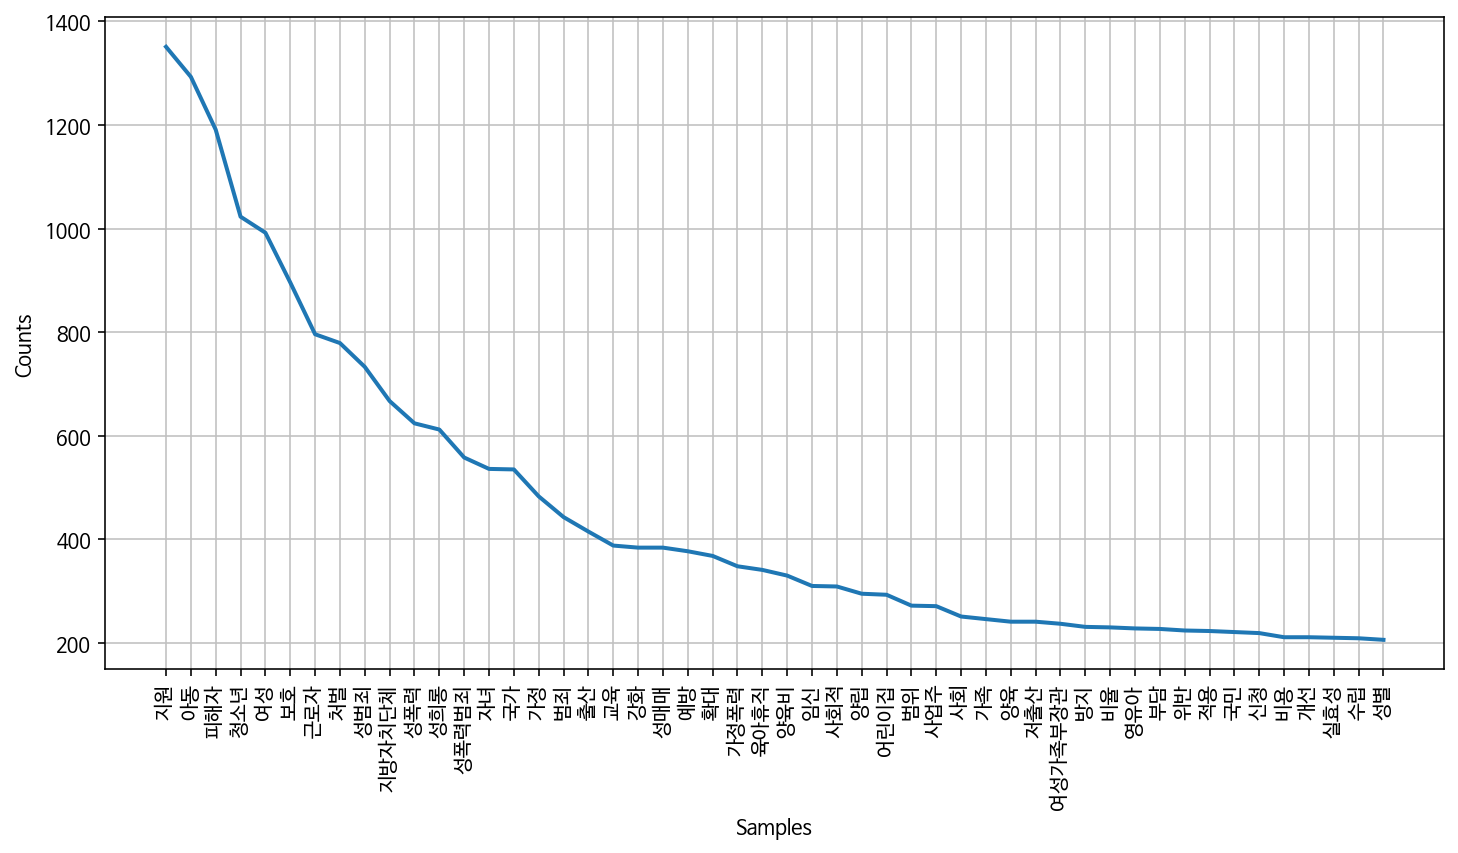

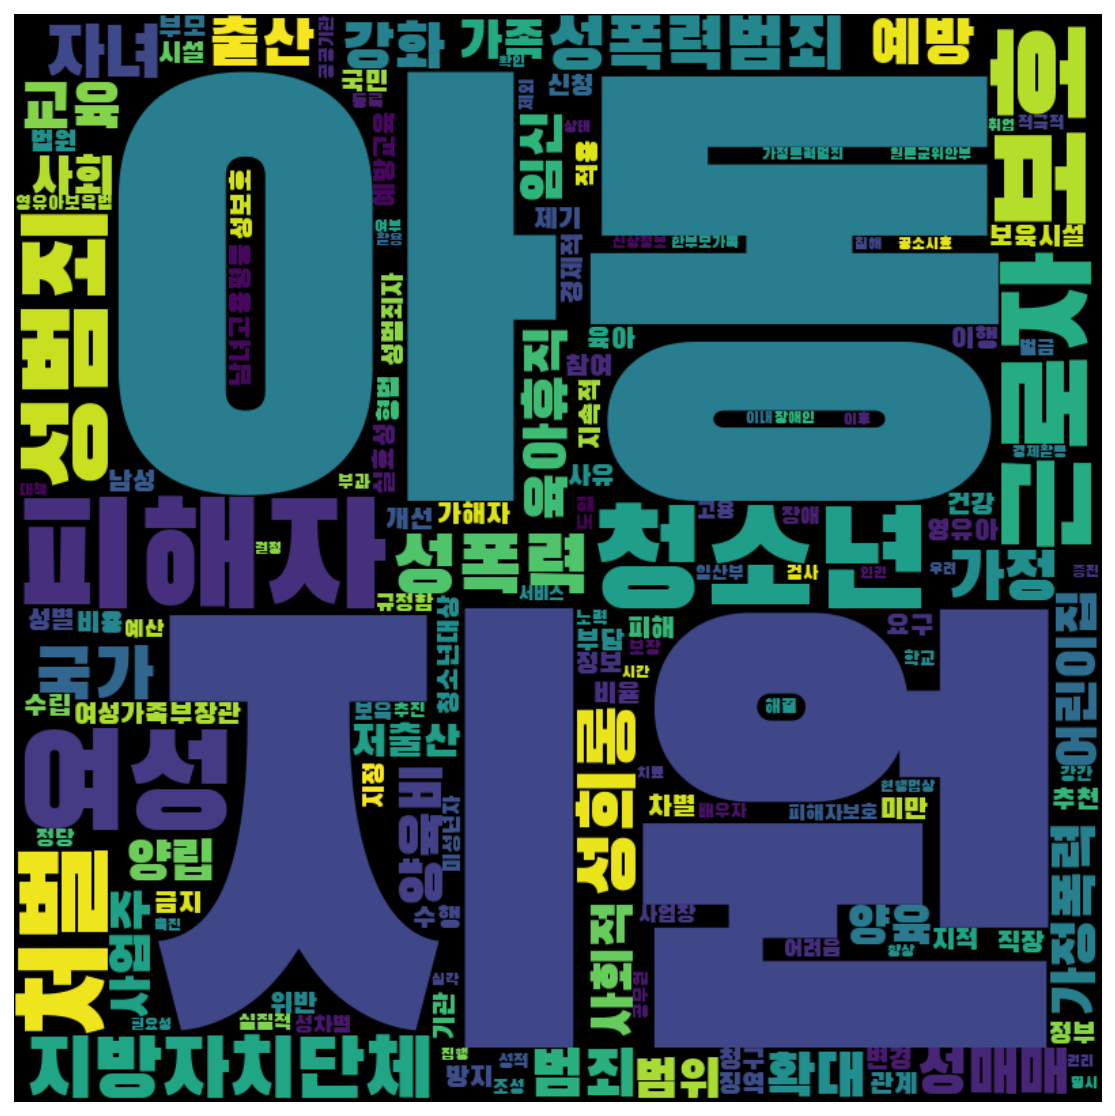

In [148]:
frewords_vis(women_word)
wordcloud_vis(women_word)

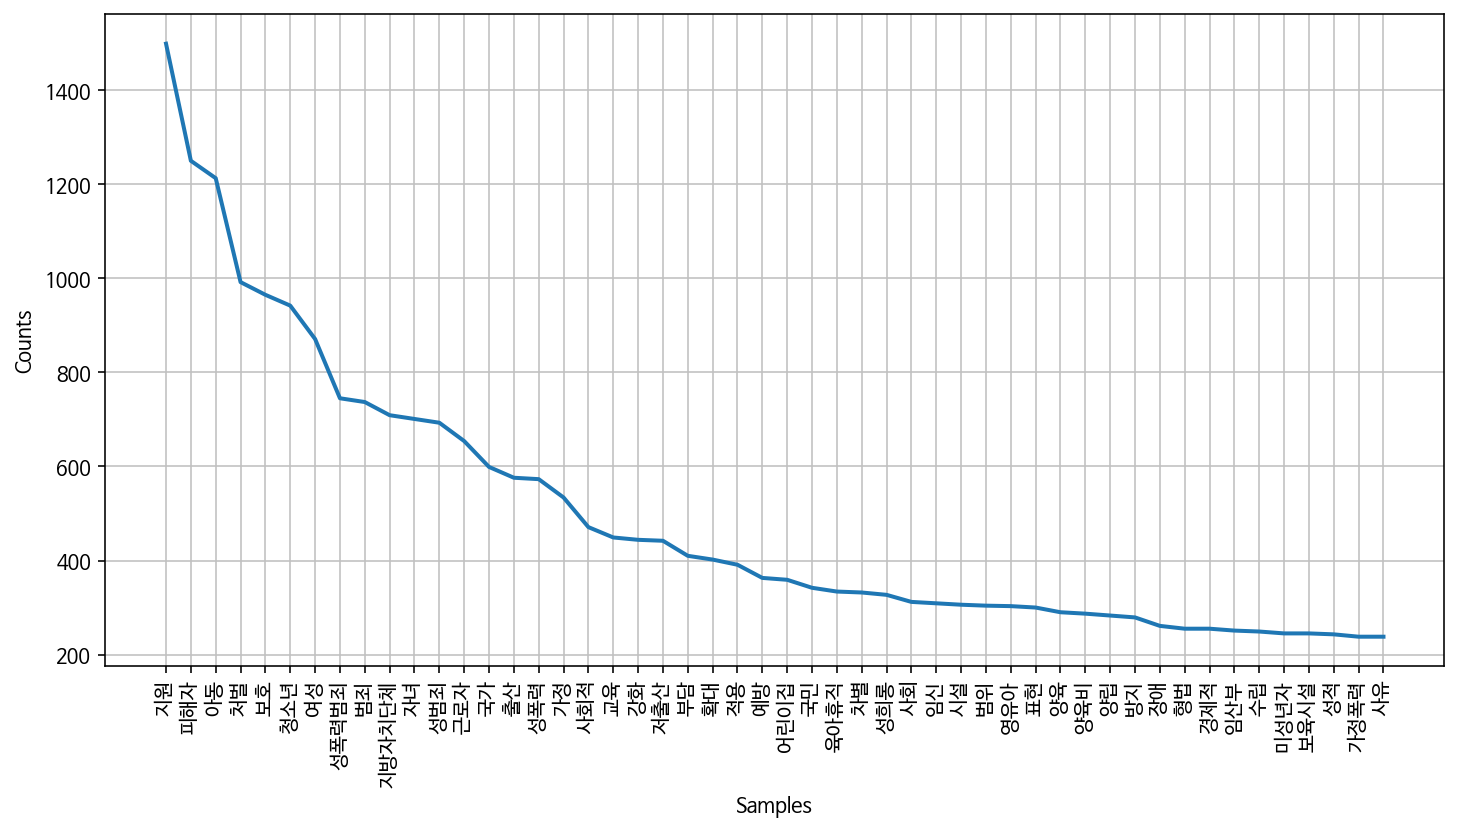

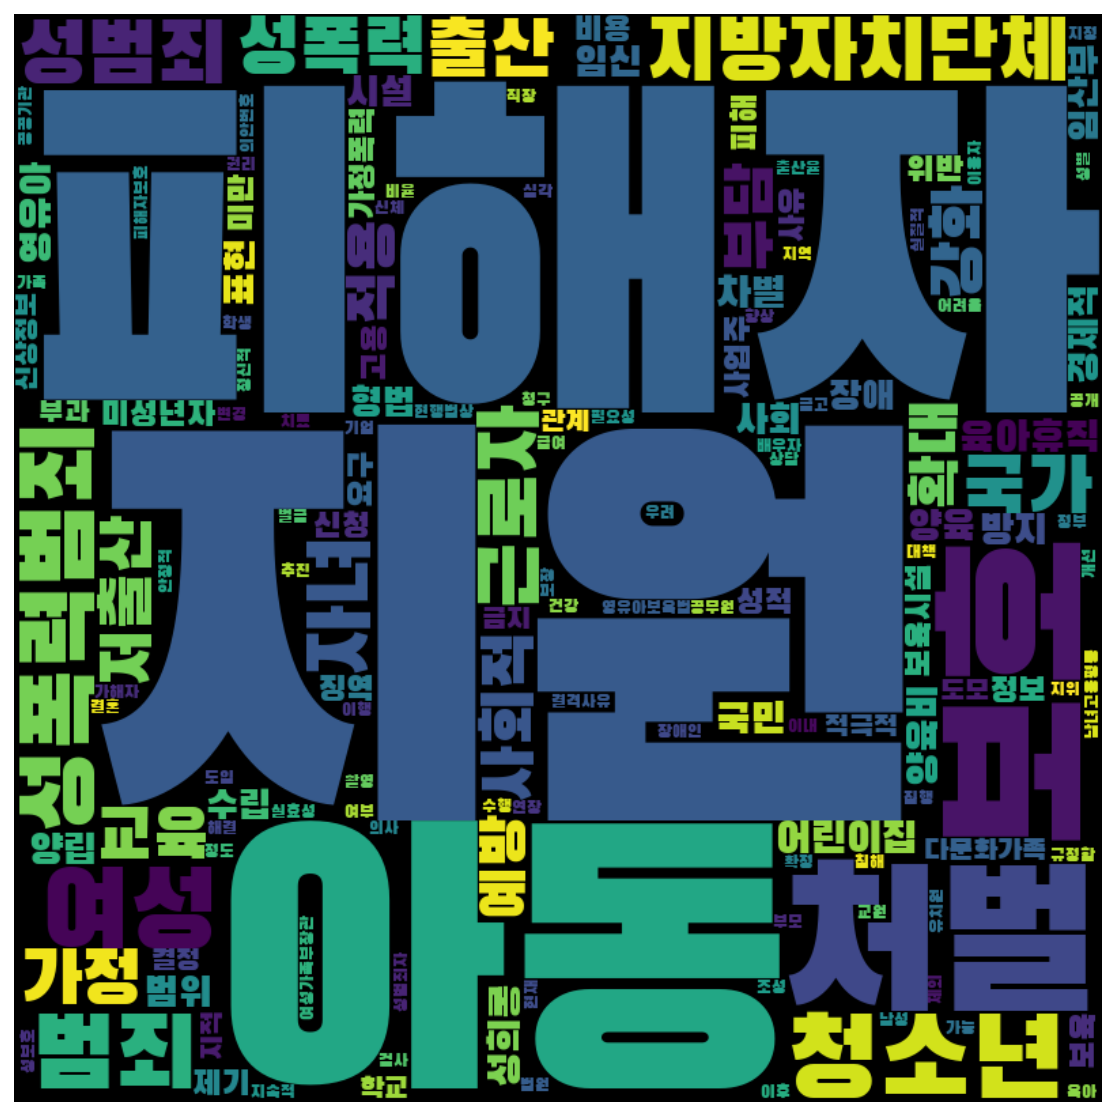

In [149]:
frewords_vis(men_word)
wordcloud_vis(men_word)

### 여성 k-means

엘보우: 100%|██████████| 14/14 [00:02<00:00,  5.47it/s]


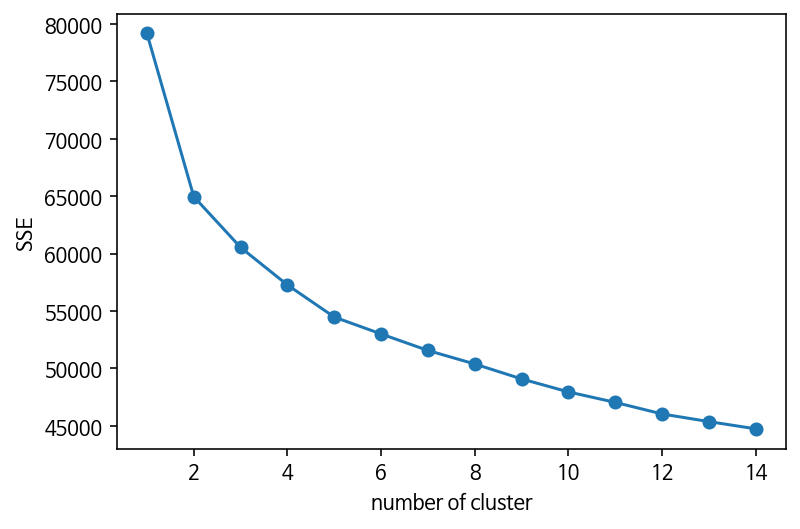

엘보우: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


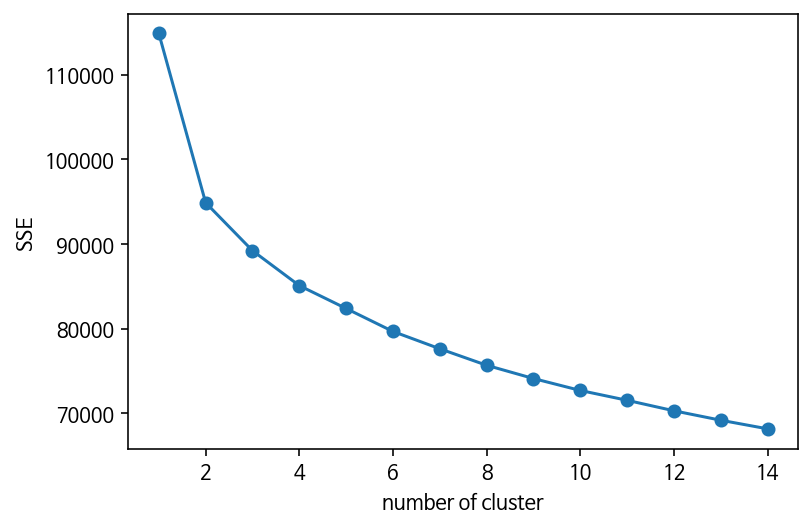

In [63]:
# 엘보우 함수로 군집 개수 결정

word_vectors_women = women['문장벡터'].to_list() # 함수에 넣을 X값 지정
elbow(word_vectors_women)

In [64]:
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
from matplotlib import cm

def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)

    silhoutte_avg = np.mean(silhouette_vals)
    plt.axvline(silhoutte_avg, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('K')
    plt.xlabel('silhouette')
    plt.show()

/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


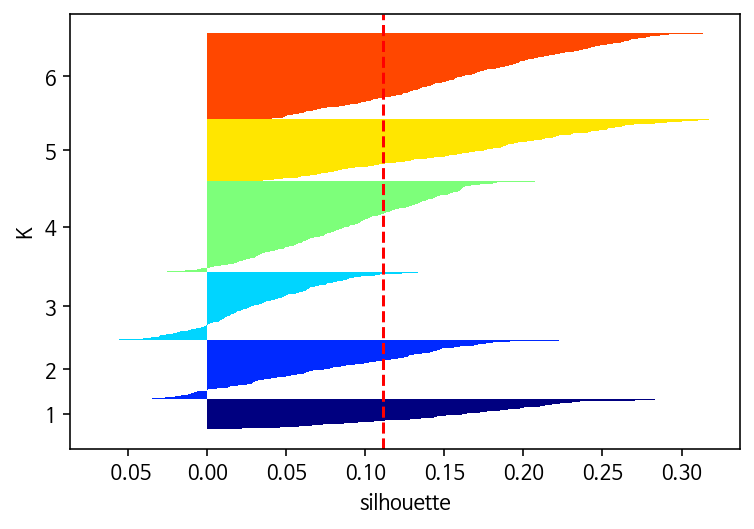

In [112]:
word_vectors_women = women['문장벡터'].to_list()
k= 6

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors_women)
plotSilhouette(word_vectors_women, y_km)

In [113]:
# K means 수행 
word_vectors_women = women['문장벡터'].to_list()
num_clusters = 6

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors_women)
women['category'] = idx

<ipython-input-113-758a1e279dd2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women['category'] = idx


In [114]:
women['category'].value_counts()

3    368
0    364
2    275
4    256
1    226
5    129
Name: category, dtype: int64

In [115]:
women_g1 = women[women['category'] == 0]
women_g2 = women[women['category'] == 1]
women_g3 = women[women['category'] == 2]
women_g4 = women[women['category'] == 3]
women_g5 = women[women['category'] == 4]
women_g6 = women[women['category'] == 5]

In [117]:
women_g1_tokens = total_tokens(women_g1['tokens'])
women_g2_tokens = total_tokens(women_g2['tokens'])
women_g3_tokens = total_tokens(women_g3['tokens'])
women_g4_tokens = total_tokens(women_g4['tokens'])
women_g5_tokens = total_tokens(women_g5['tokens'])
women_g6_tokens = total_tokens(women_g6['tokens'])

In [118]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출',
            '신설','대상','문제','제공','항제','사용','근거','불구','범위','이유','증가']
women_g1_tokens = [each_word for each_word in women_g1_tokens if each_word not in stopwords]
women_g2_tokens = [each_word for each_word in women_g2_tokens if each_word not in stopwords]
women_g3_tokens = [each_word for each_word in women_g3_tokens if each_word not in stopwords]
women_g4_tokens = [each_word for each_word in women_g4_tokens if each_word not in stopwords]
women_g5_tokens = [each_word for each_word in women_g5_tokens if each_word not in stopwords]
women_g6_tokens = [each_word for each_word in women_g6_tokens if each_word not in stopwords]

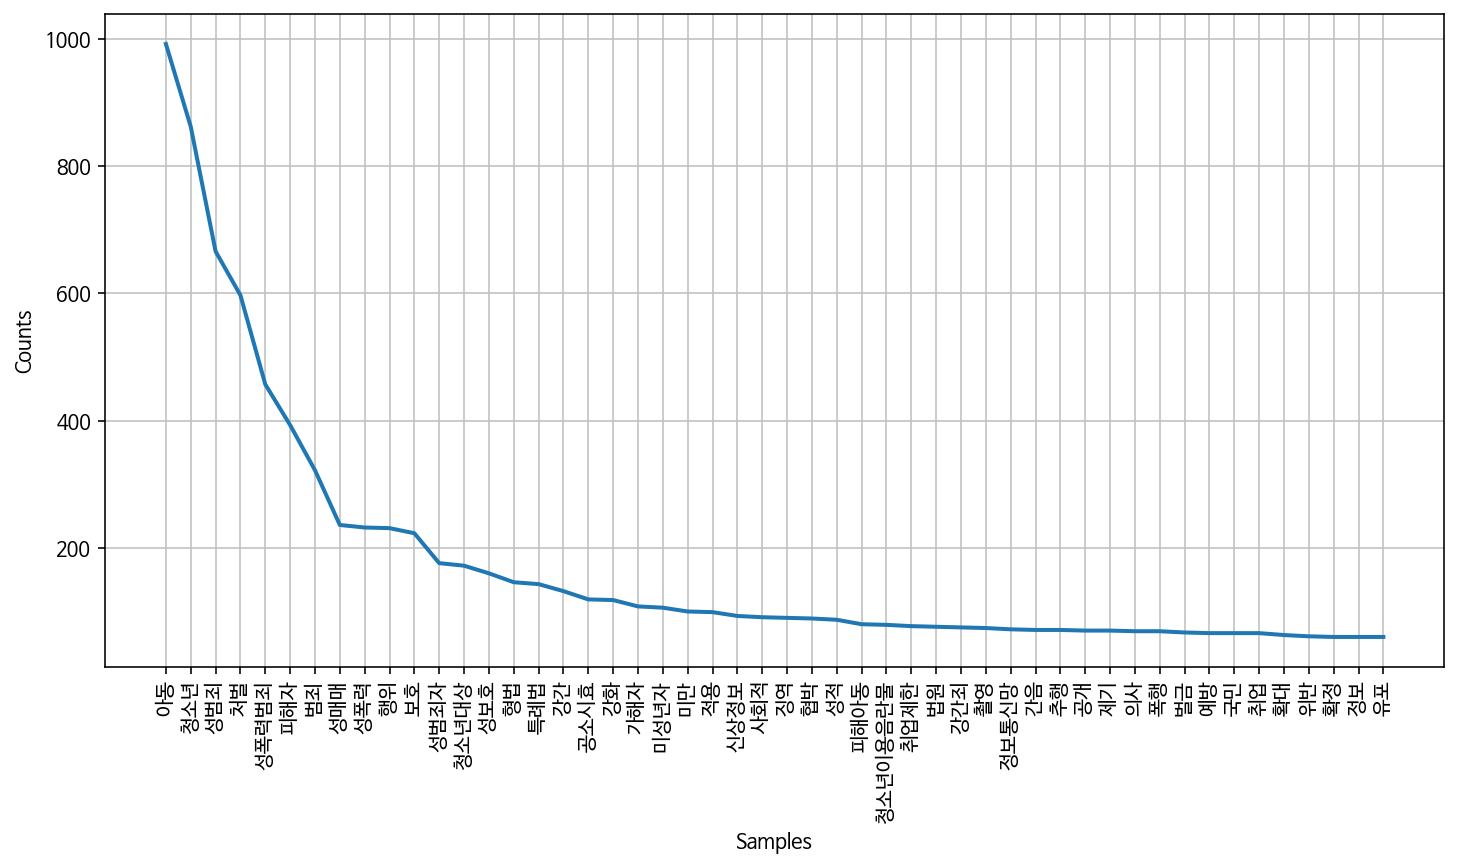

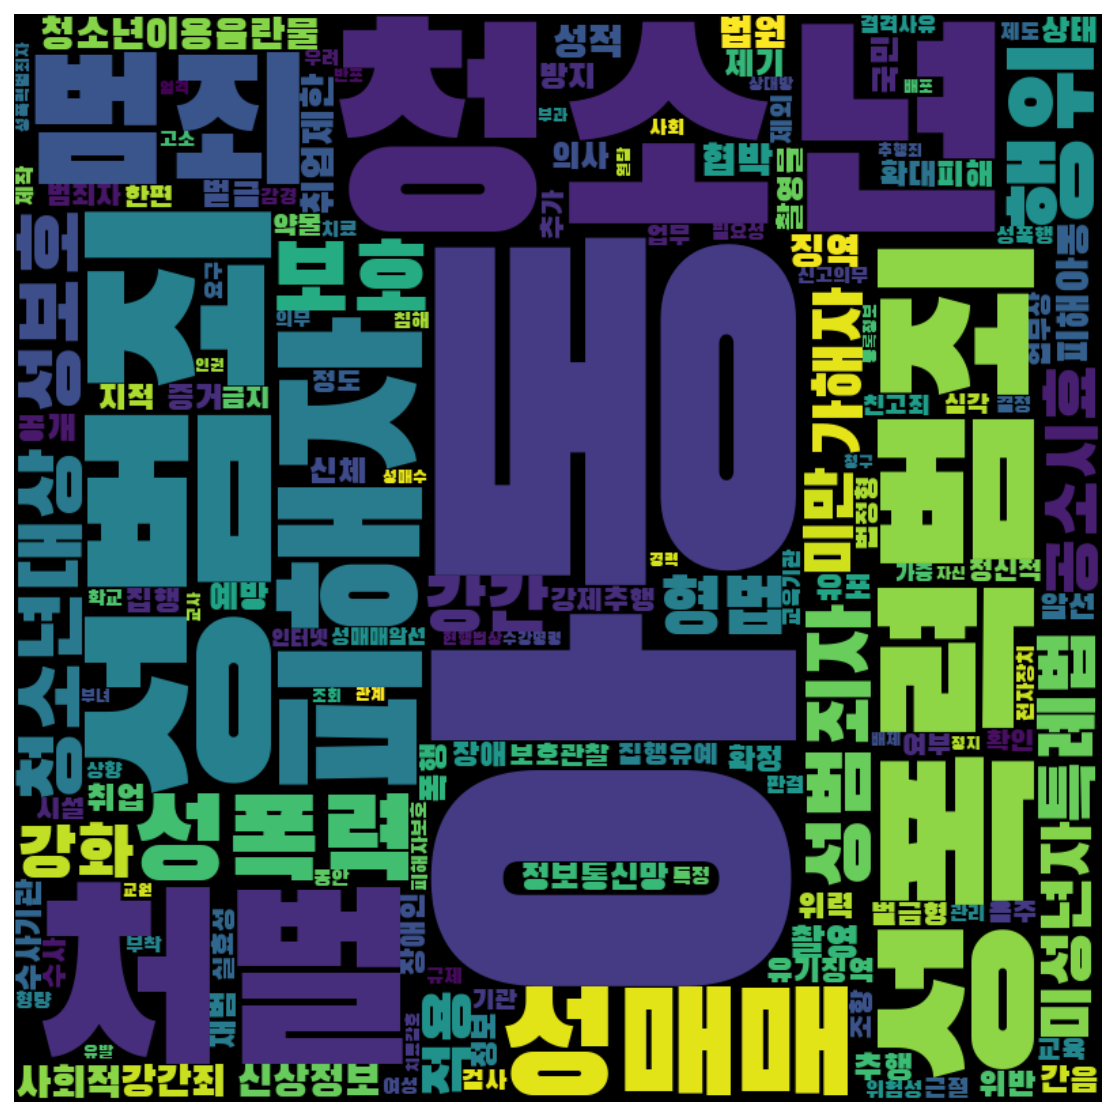

In [119]:
frewords_vis(women_g1_tokens)
wordcloud_vis(women_g1_tokens)

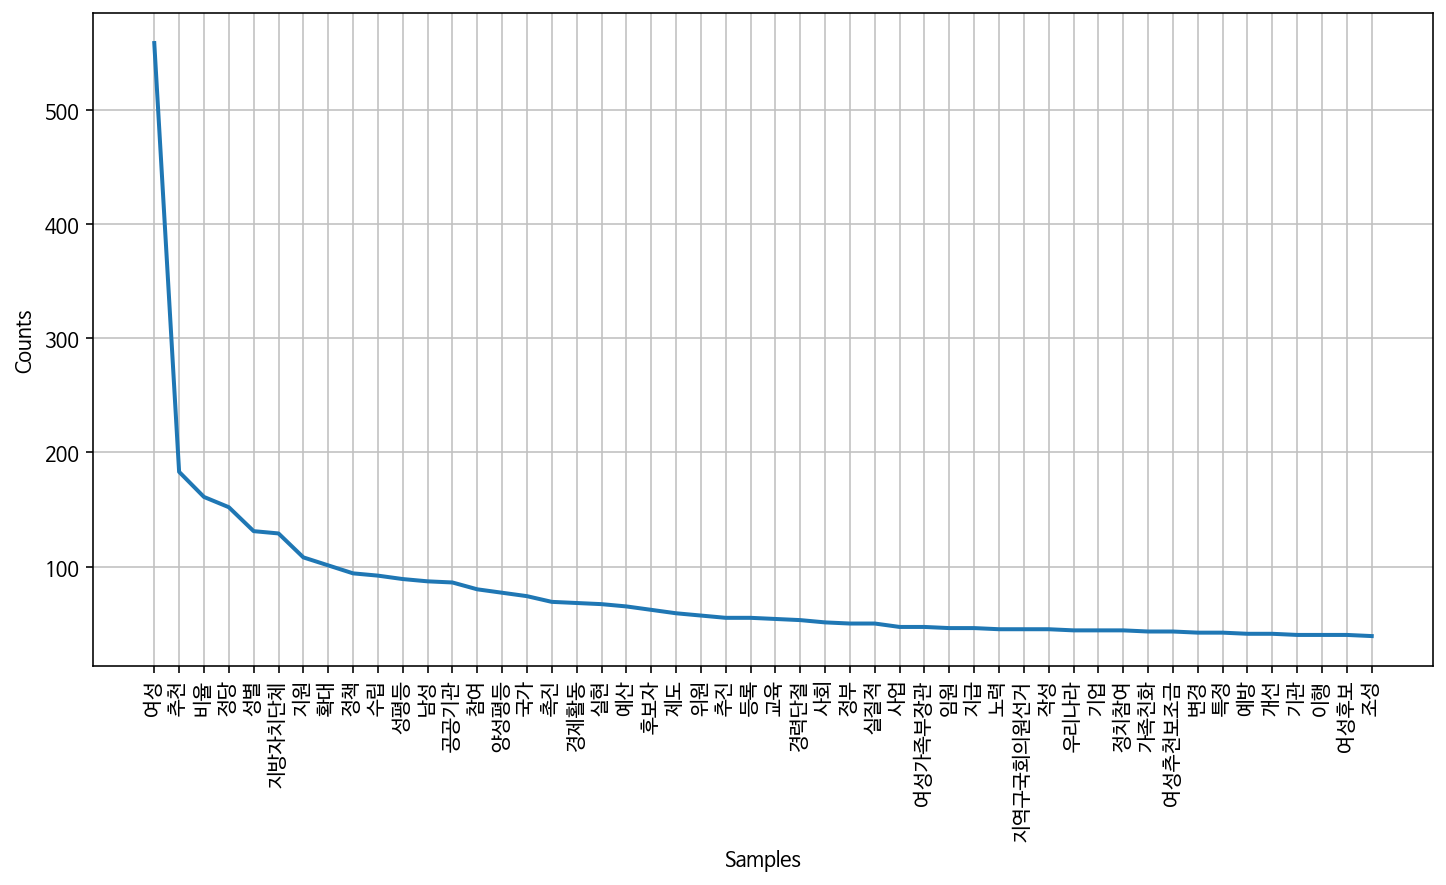

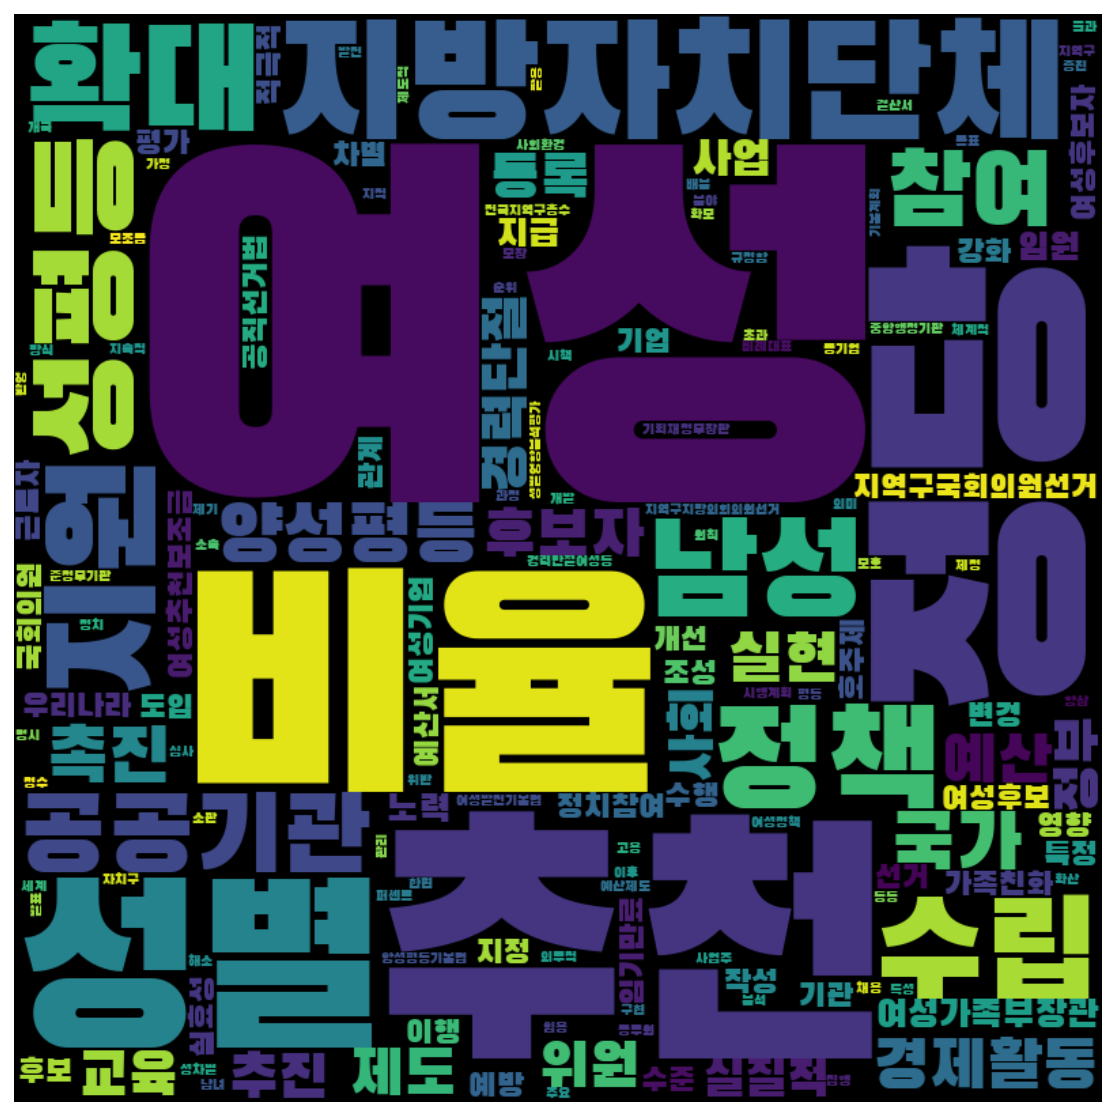

In [120]:
frewords_vis(women_g2_tokens)
wordcloud_vis(women_g2_tokens)

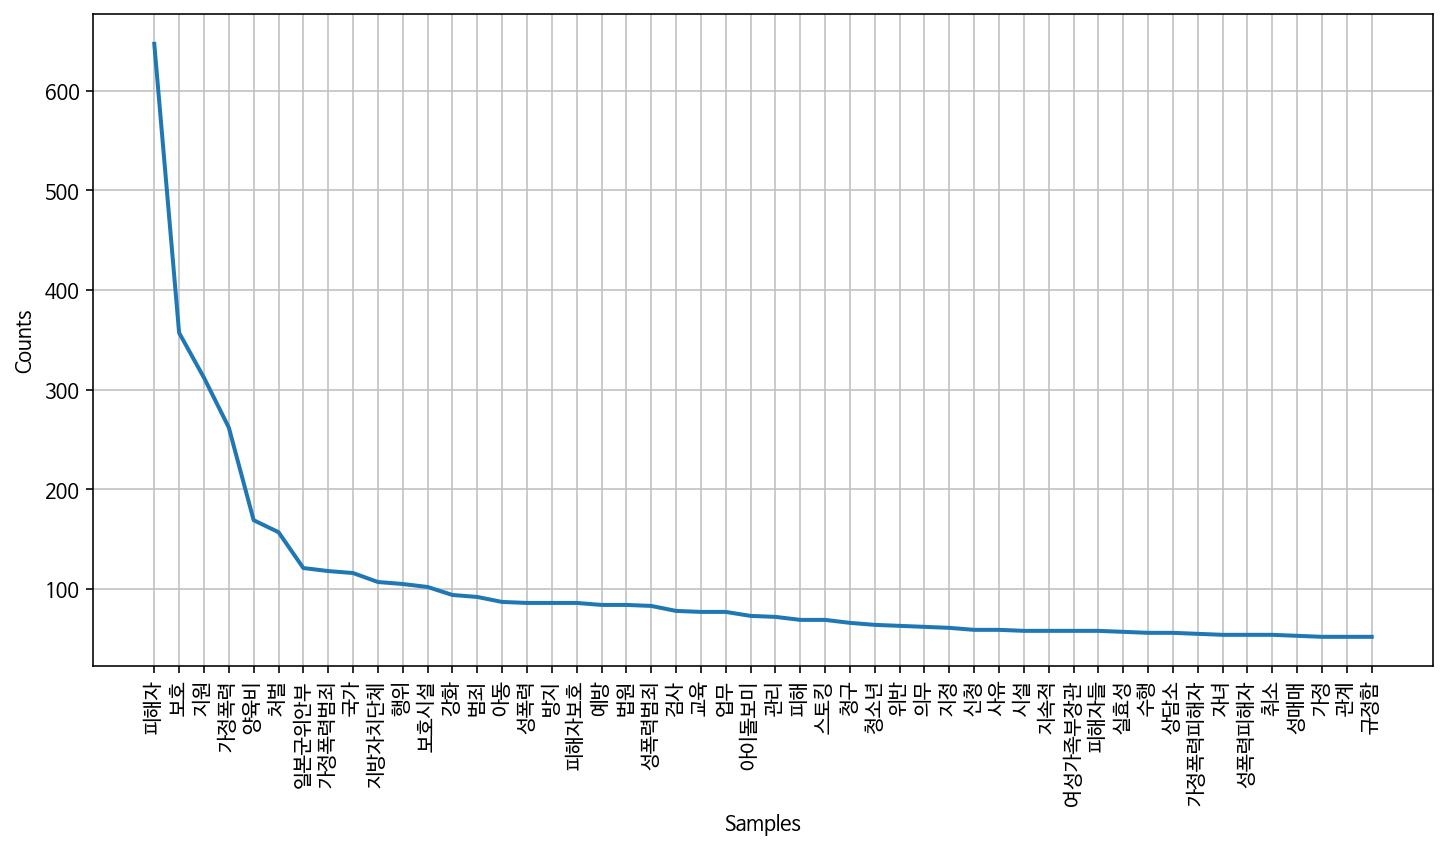

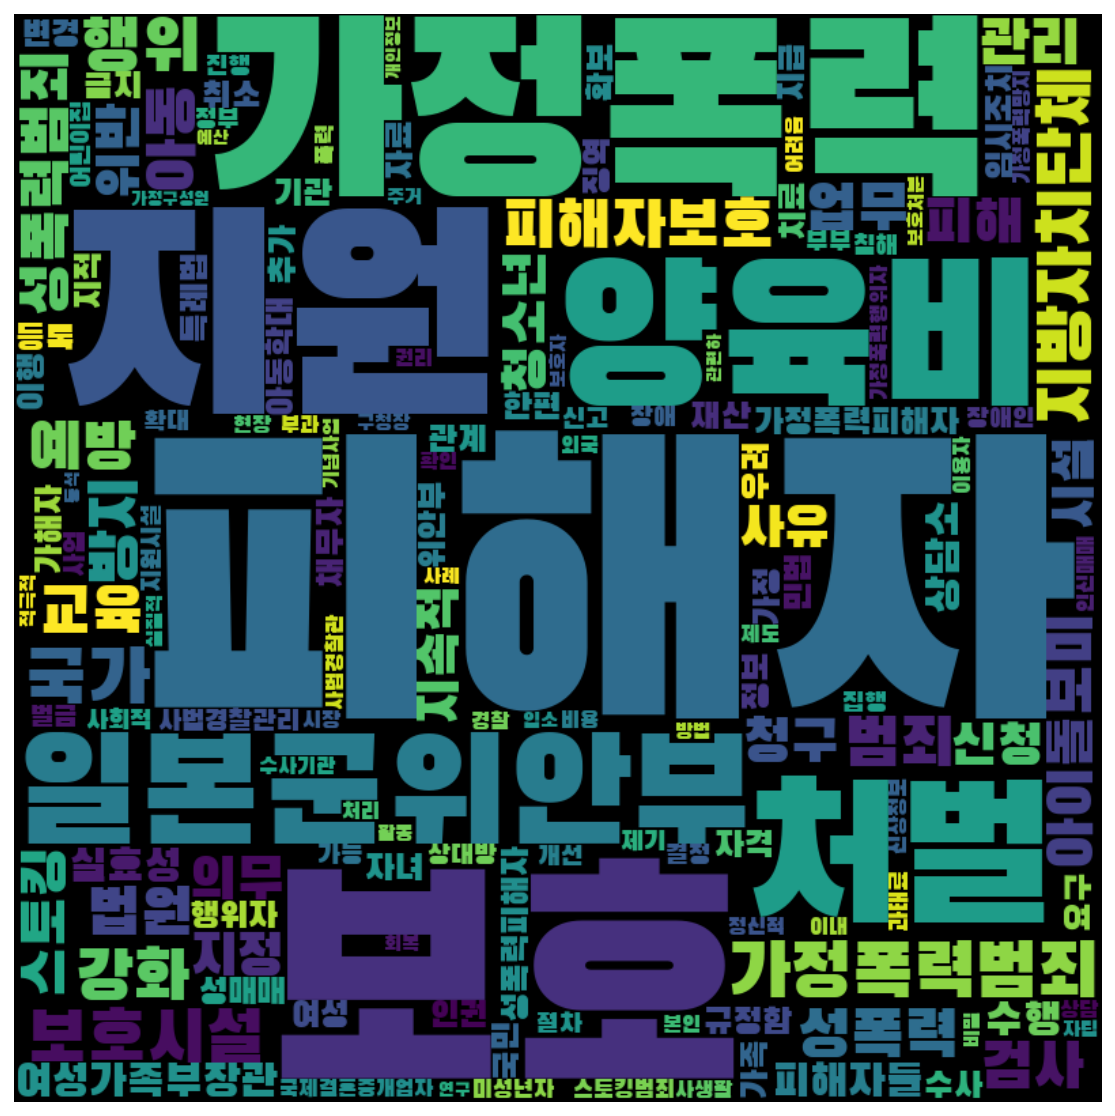

In [121]:
frewords_vis(women_g3_tokens)
wordcloud_vis(women_g3_tokens)

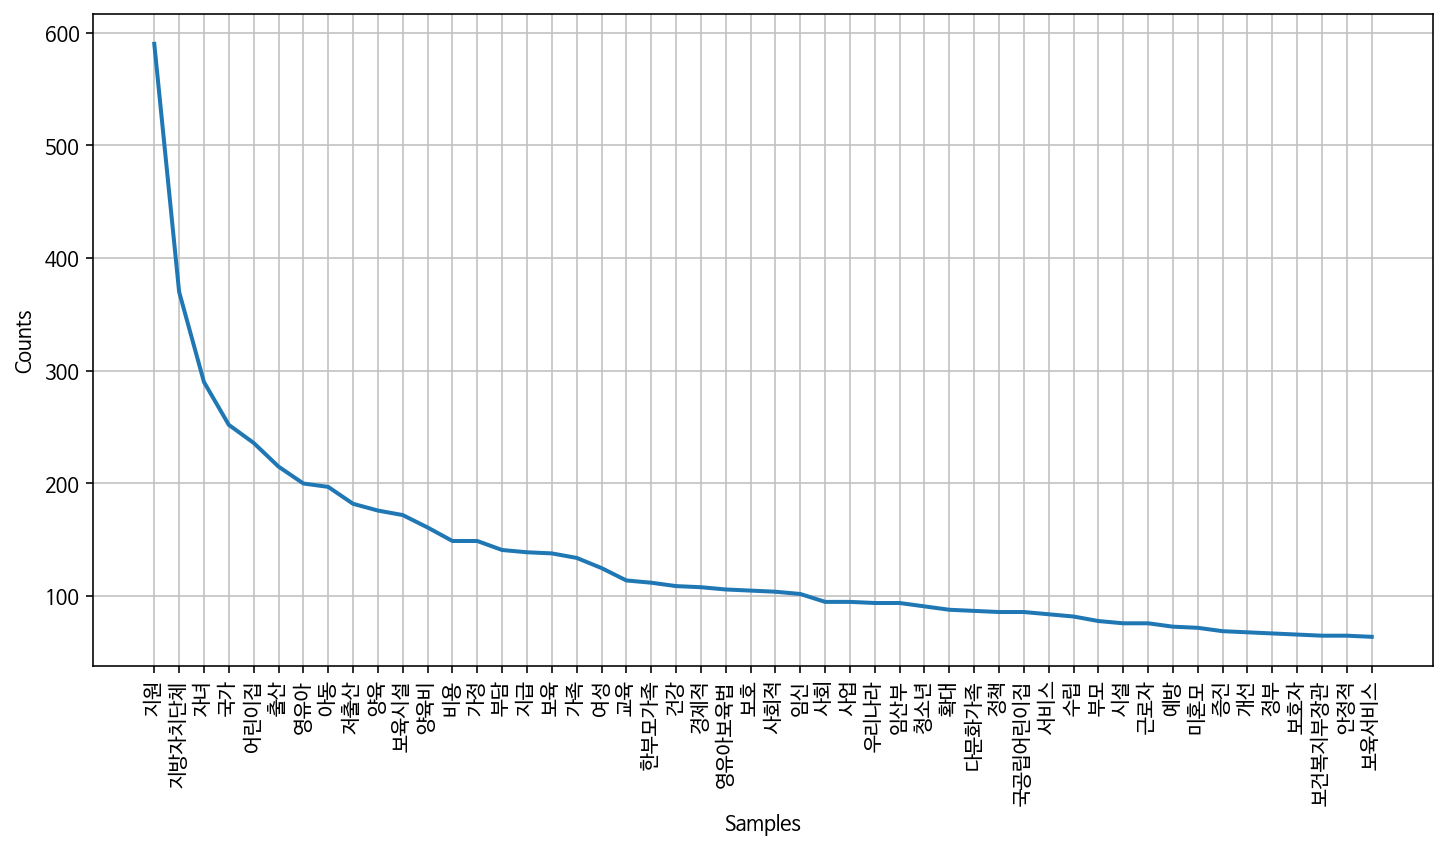

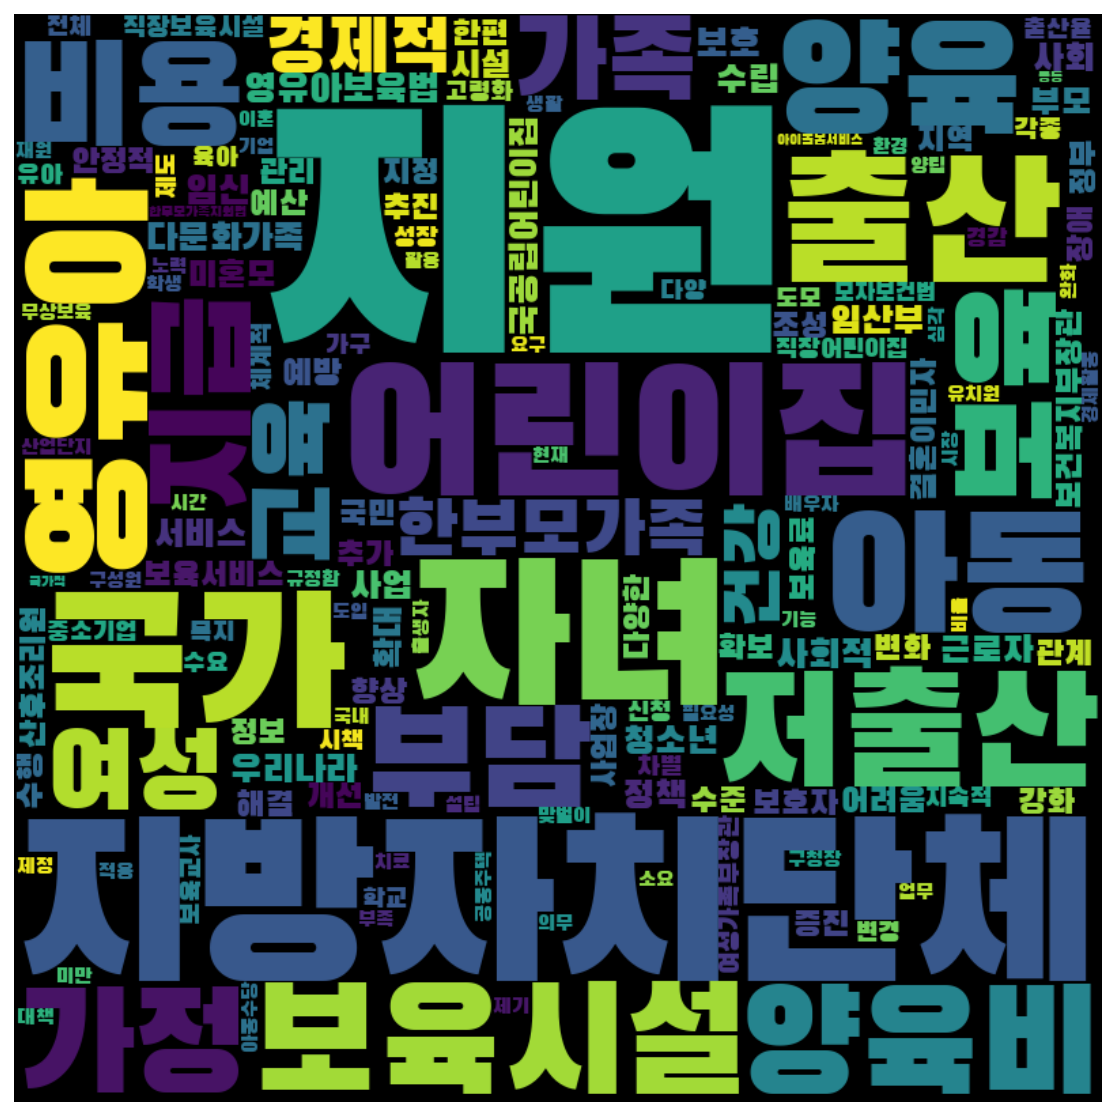

In [122]:
frewords_vis(women_g4_tokens)
wordcloud_vis(women_g4_tokens)

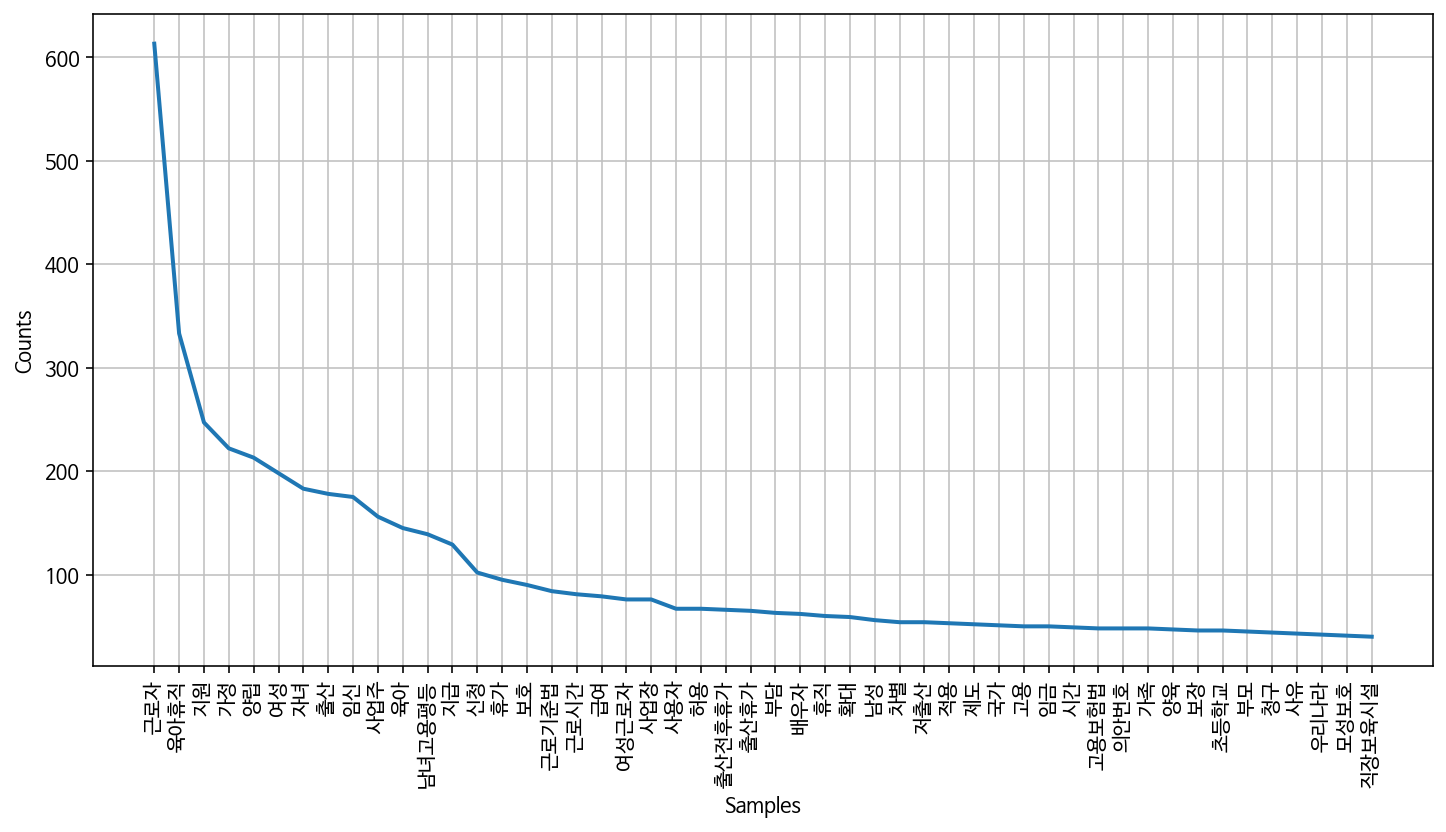

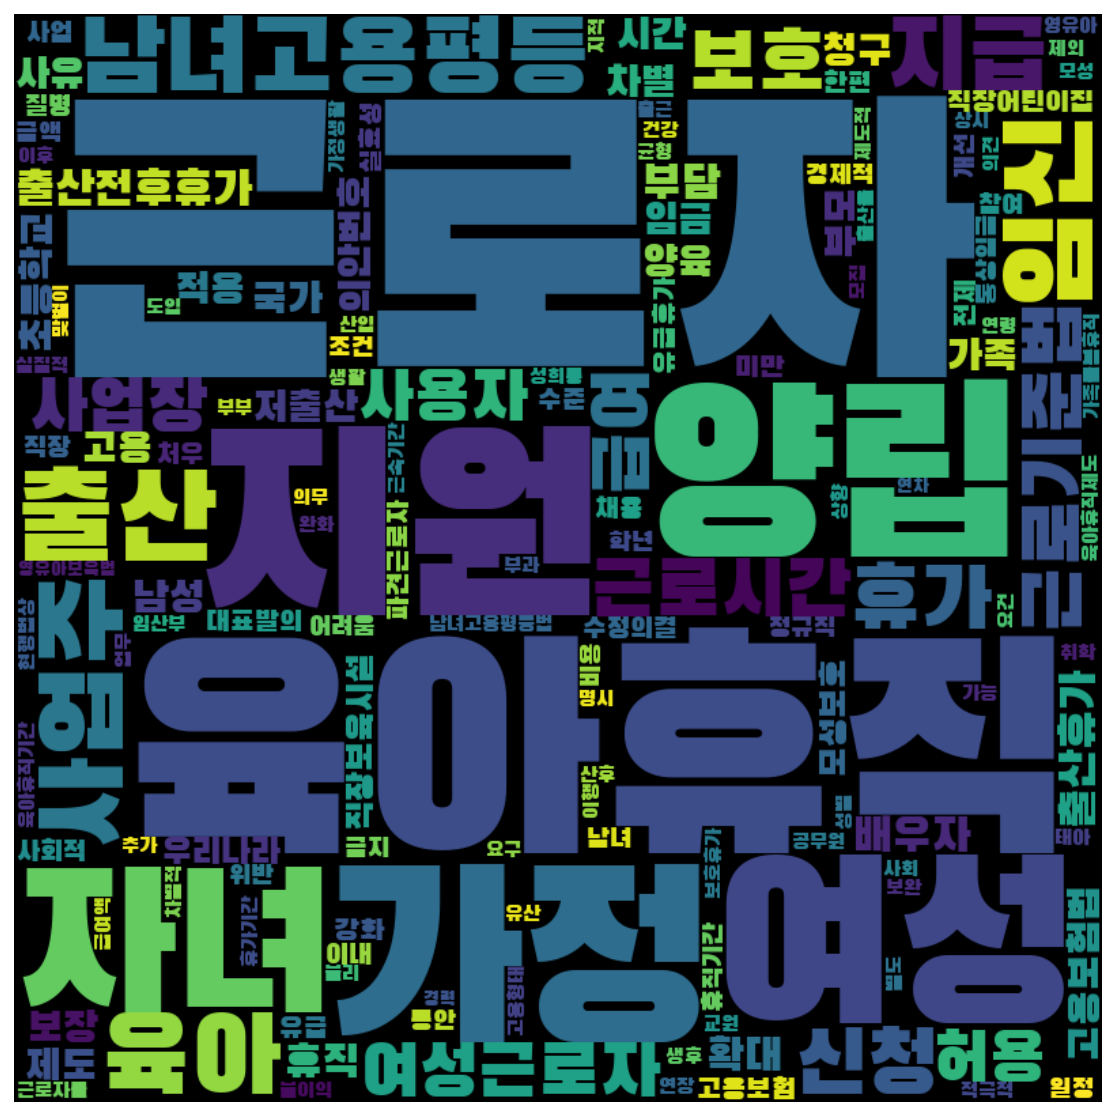

In [123]:
frewords_vis(women_g5_tokens)
wordcloud_vis(women_g5_tokens)

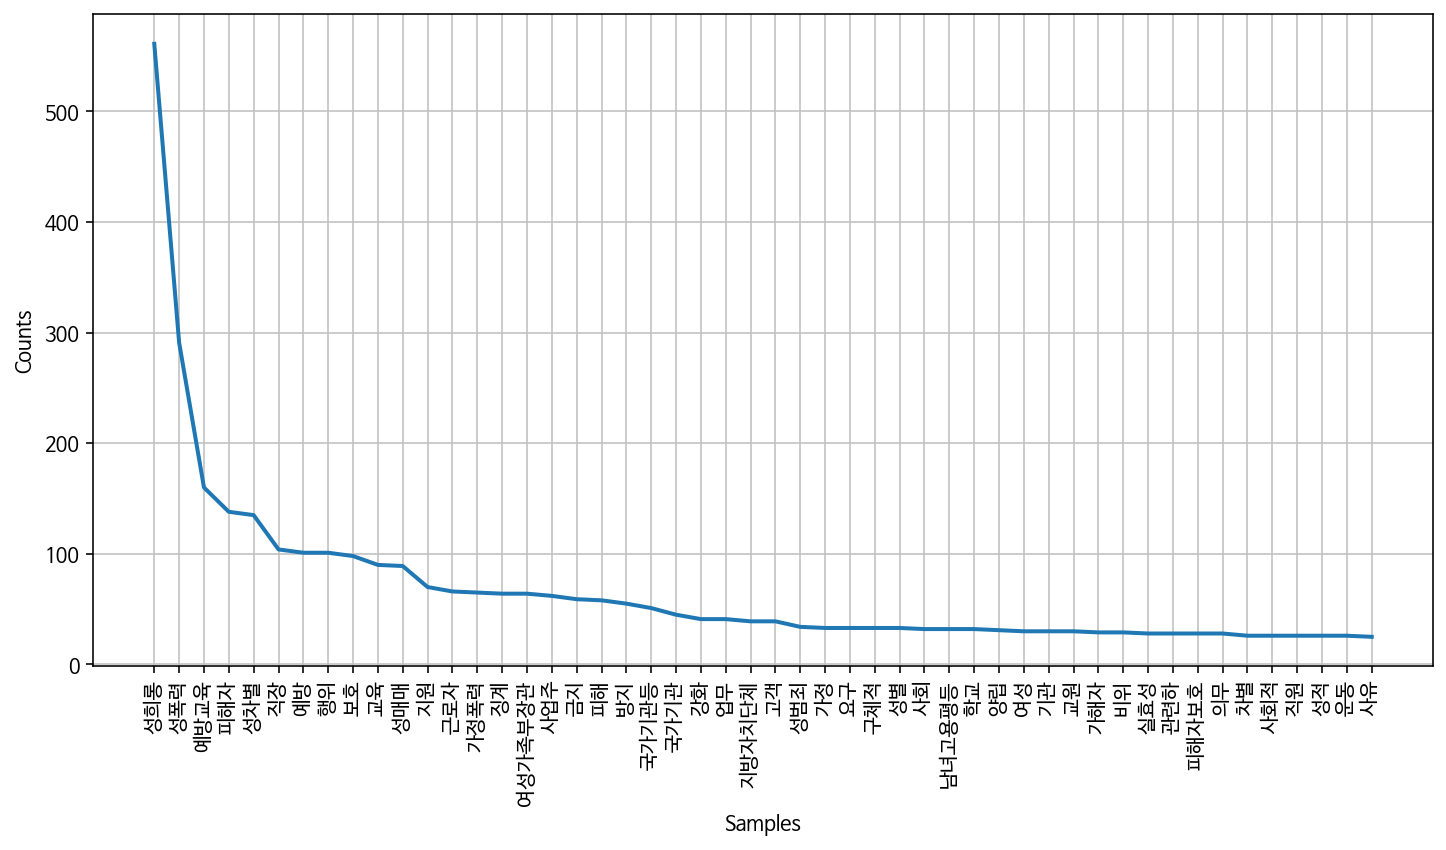

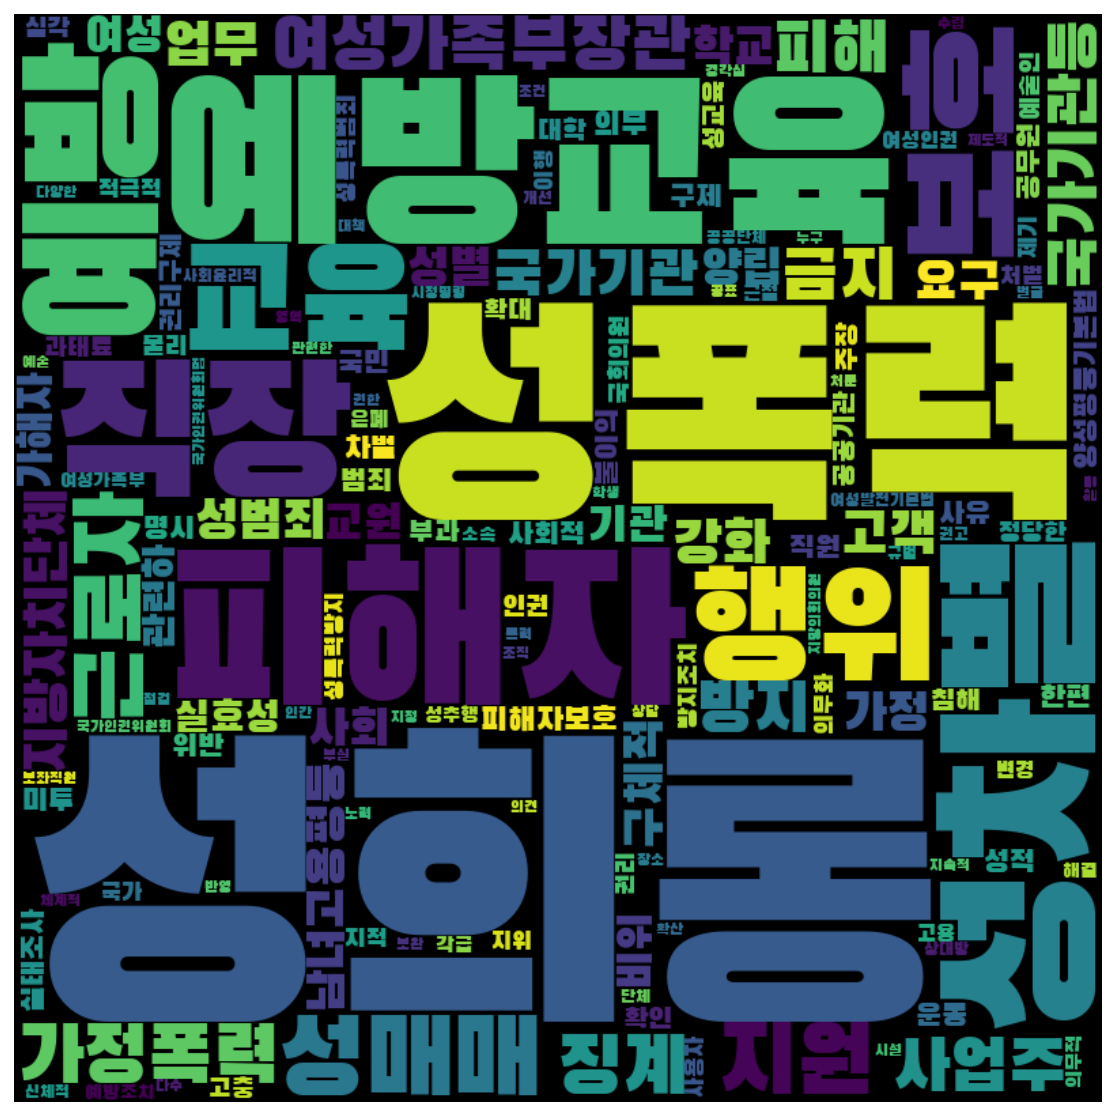

In [124]:
frewords_vis(women_g6_tokens)
wordcloud_vis(women_g6_tokens)

### 남성 k-means

엘보우: 100%|██████████| 14/14 [00:03<00:00,  4.06it/s]


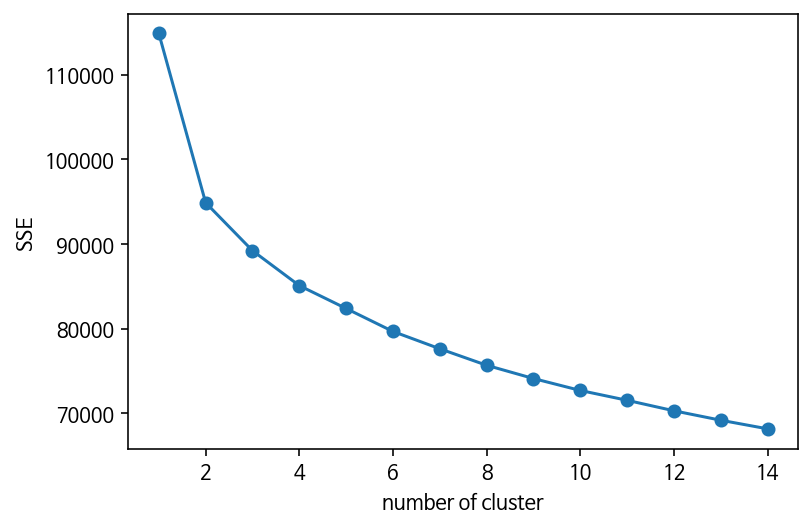

In [83]:
word_vectors_men = men['문장벡터'].to_list() # 함수에 넣을 X값 지정
elbow(word_vectors_men)

/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


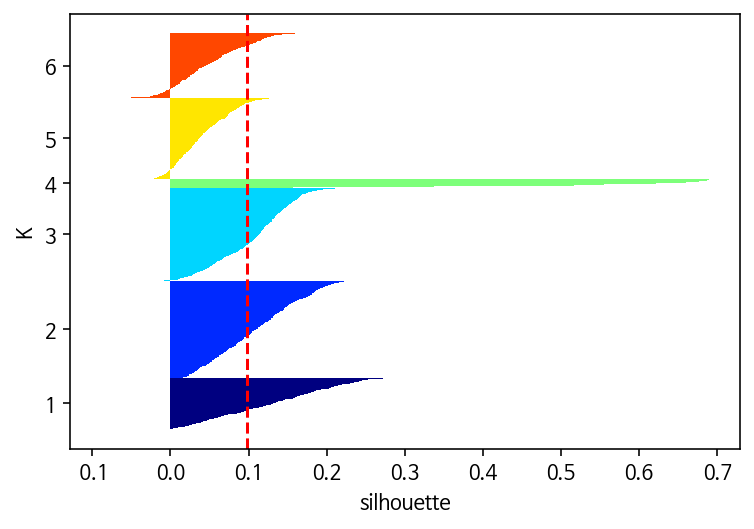

In [84]:
word_vectors_men = men['문장벡터'].to_list()
k= 6

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors_men)
plotSilhouette(word_vectors_men, y_km)

In [85]:
# K means 수행 
word_vectors_men = men['문장벡터'].to_list()
num_clusters = 6

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors_men)
men['category'] = idx

<ipython-input-85-ea17c2f5c726>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men['category'] = idx


In [86]:
men['category'].value_counts()

2    526
4    501
3    443
1    349
0    272
5     47
Name: category, dtype: int64

In [89]:
men_g1 = men[men['category'] == 0]
men_g2 = men[men['category'] == 1]
men_g3 = men[men['category'] == 2]
men_g4 = men[men['category'] == 3]
men_g5 = men[men['category'] == 4]
men_g6 = men[men['category'] == 5]

In [90]:
men_g1_tokens = total_tokens(men_g1['tokens'])
men_g2_tokens = total_tokens(men_g2['tokens'])
men_g3_tokens = total_tokens(men_g3['tokens'])
men_g4_tokens = total_tokens(men_g4['tokens'])
men_g5_tokens = total_tokens(men_g5['tokens'])
men_g6_tokens = total_tokens(men_g6['tokens'])

In [93]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출','신설',
            '신설','대상','문제','제공','항제','사용','근거','불구','범위','이유','증가']
men_g1_tokens = [each_word for each_word in men_g1_tokens if each_word not in stopwords]
men_g2_tokens = [each_word for each_word in men_g2_tokens if each_word not in stopwords]
men_g3_tokens = [each_word for each_word in men_g3_tokens if each_word not in stopwords]
men_g4_tokens = [each_word for each_word in men_g4_tokens if each_word not in stopwords]
men_g5_tokens = [each_word for each_word in men_g5_tokens if each_word not in stopwords]
men_g6_tokens = [each_word for each_word in men_g6_tokens if each_word not in stopwords]

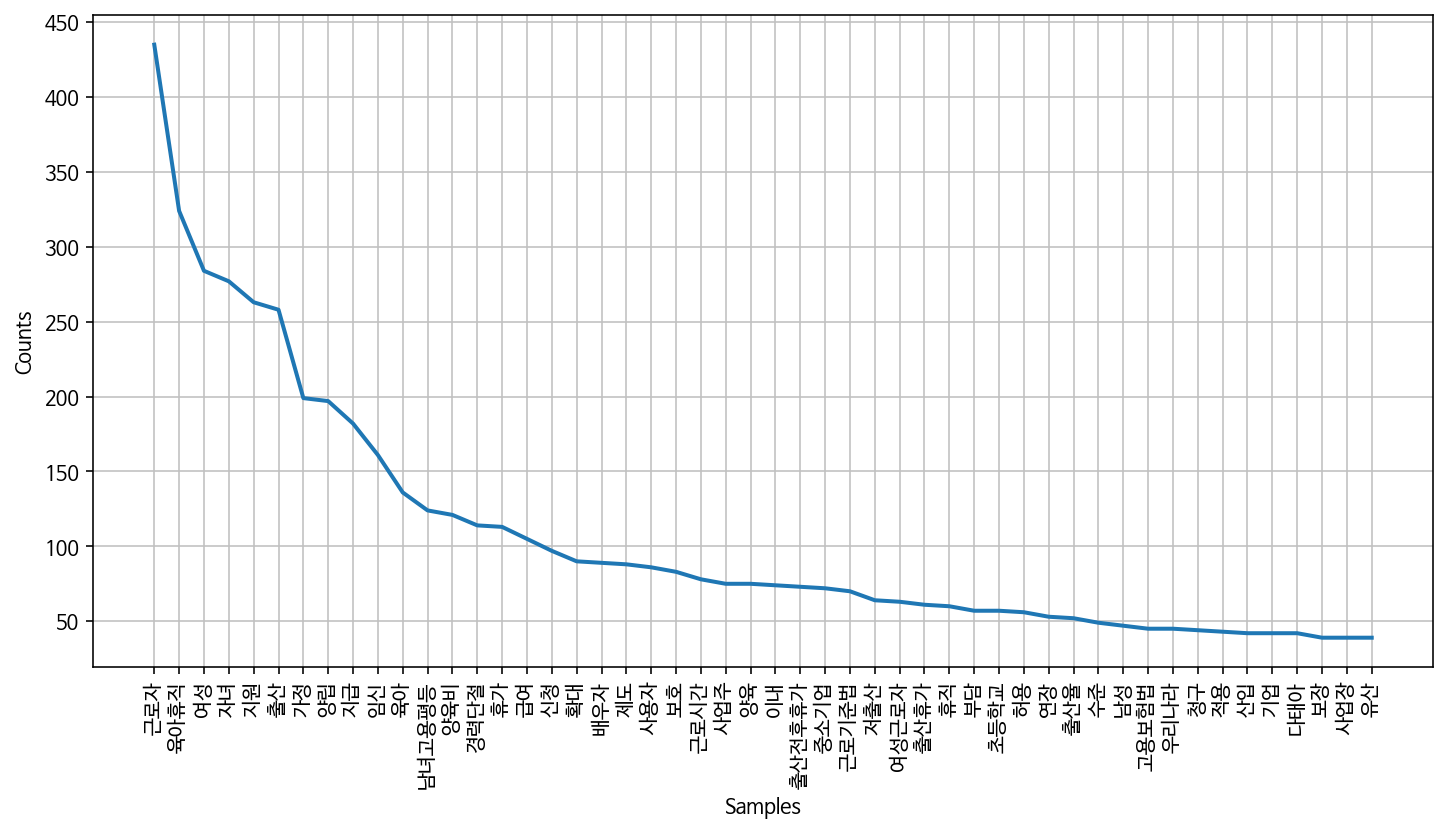

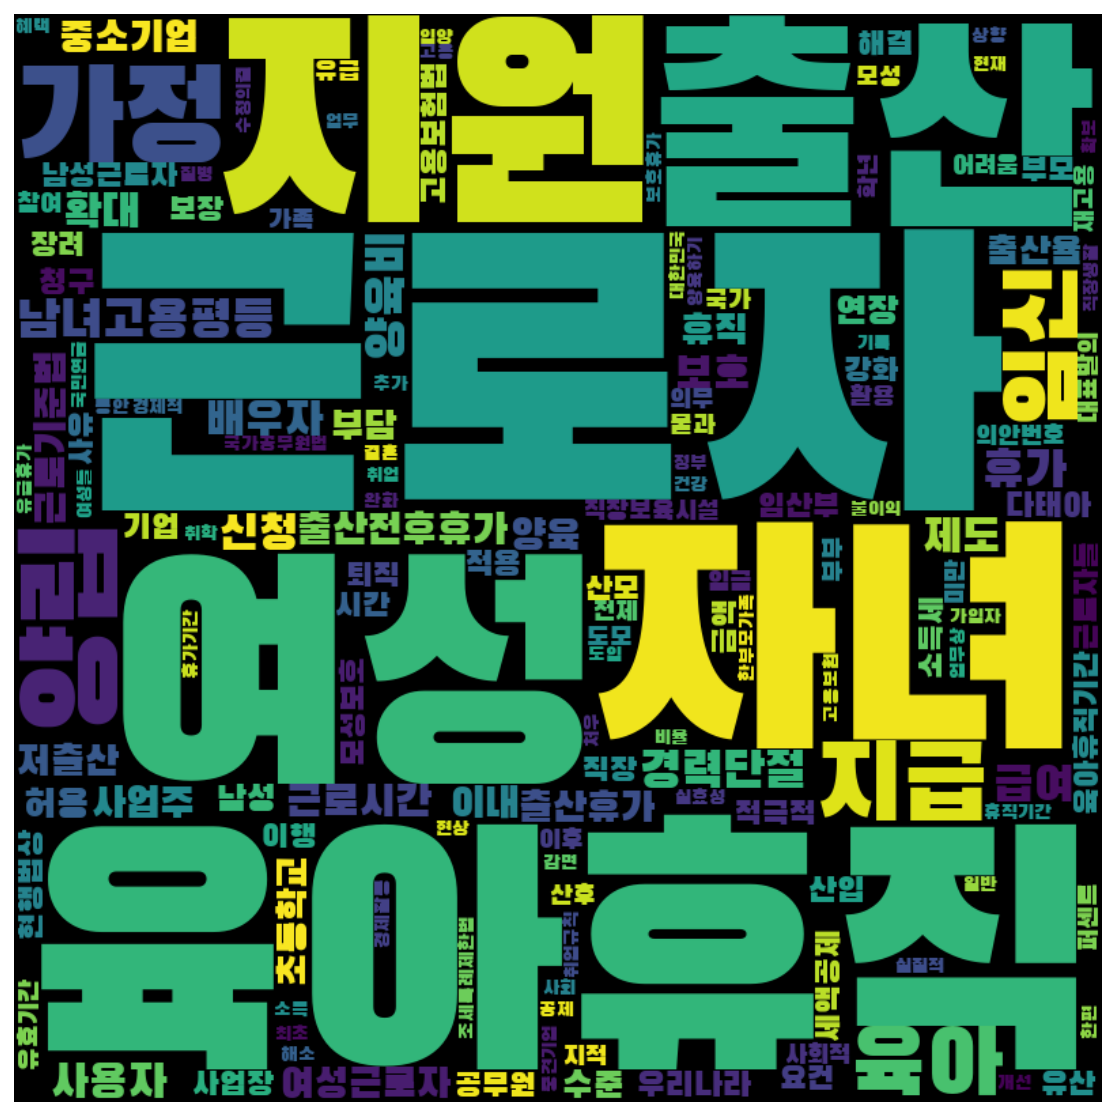

In [100]:
frewords_vis(men_g1_tokens)
wordcloud_vis(men_g1_tokens)

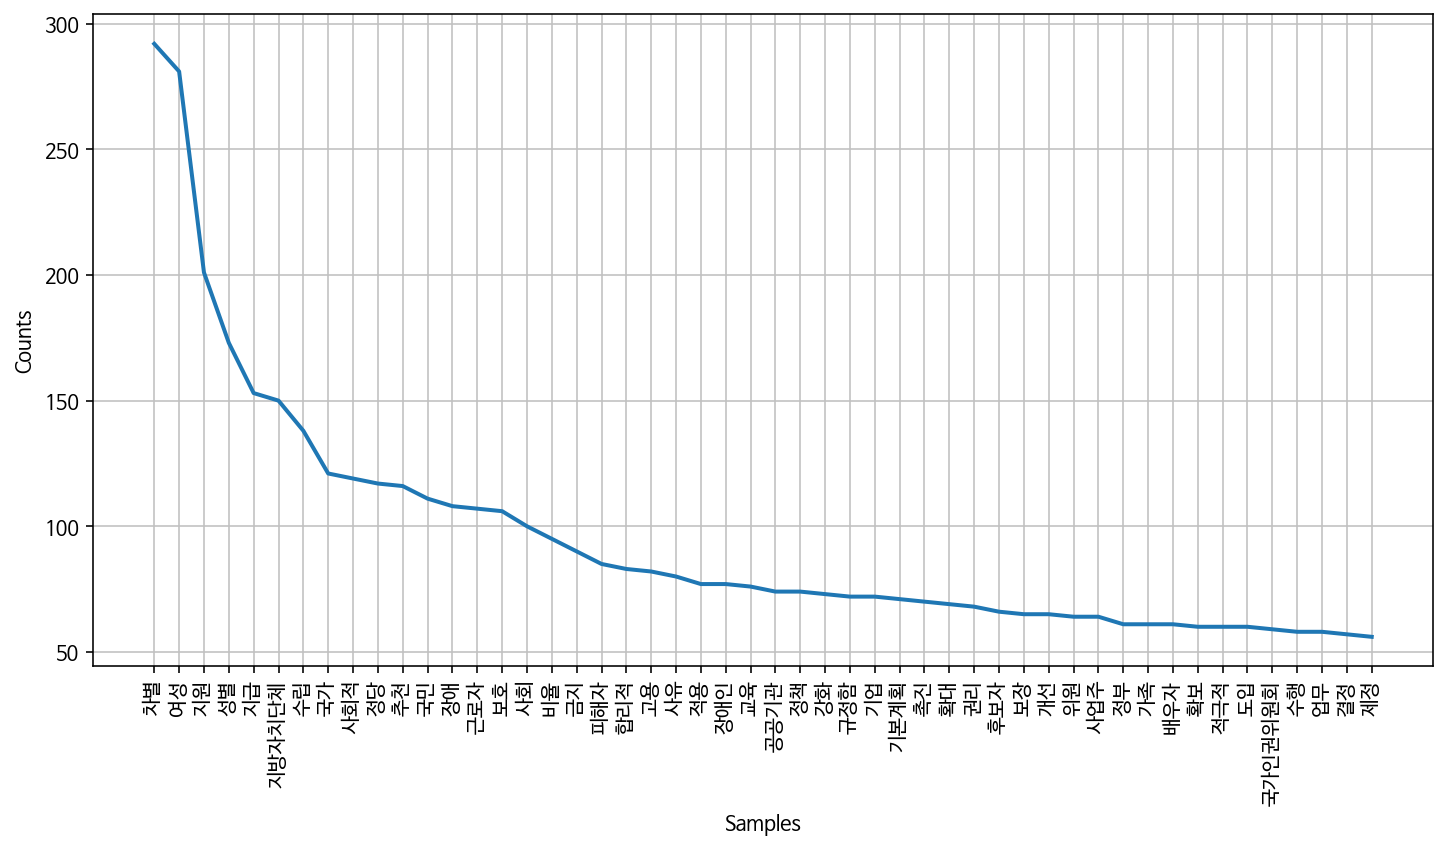

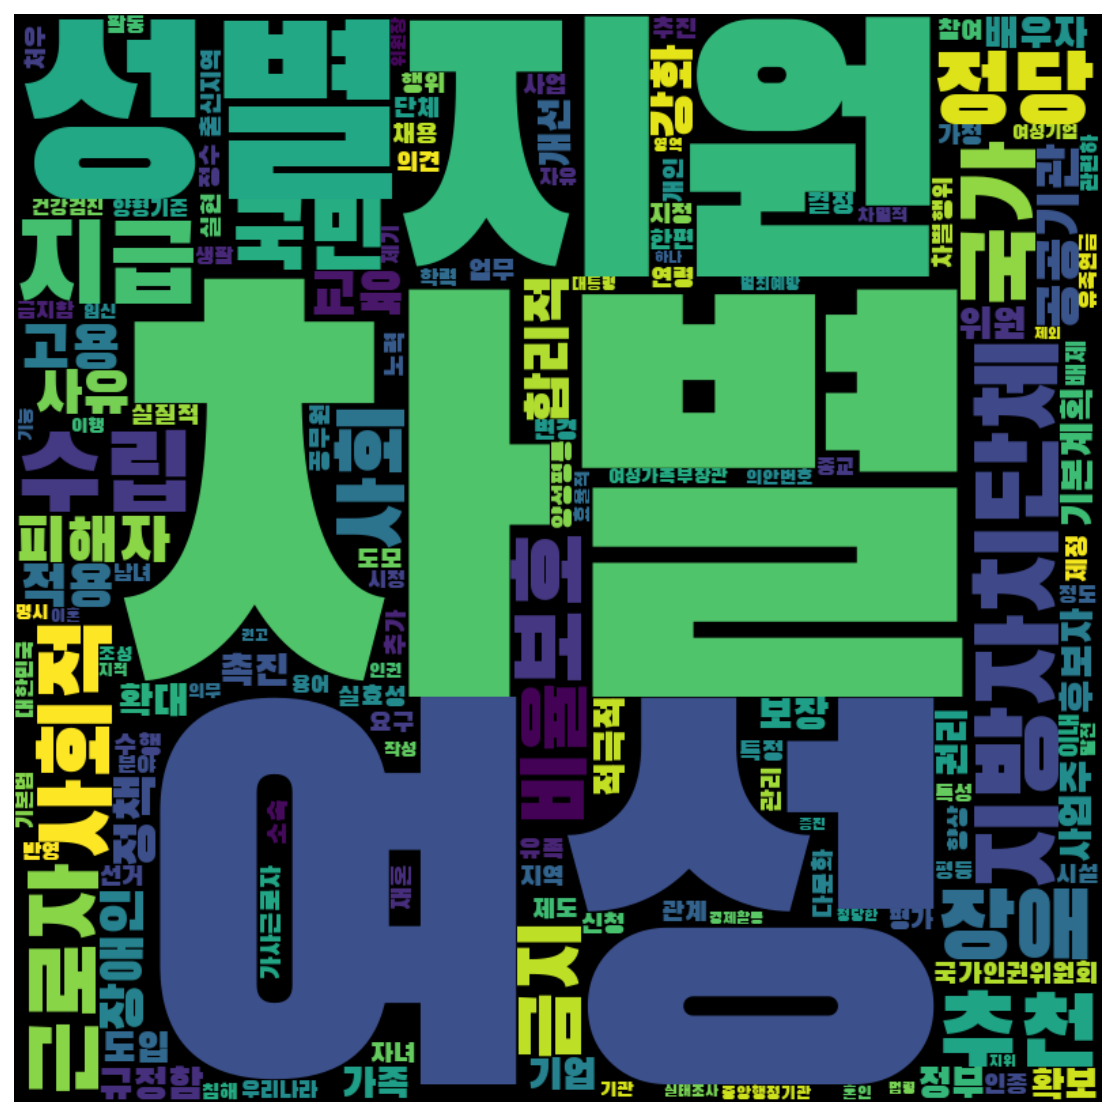

In [101]:
frewords_vis(men_g2_tokens)
wordcloud_vis(men_g2_tokens)

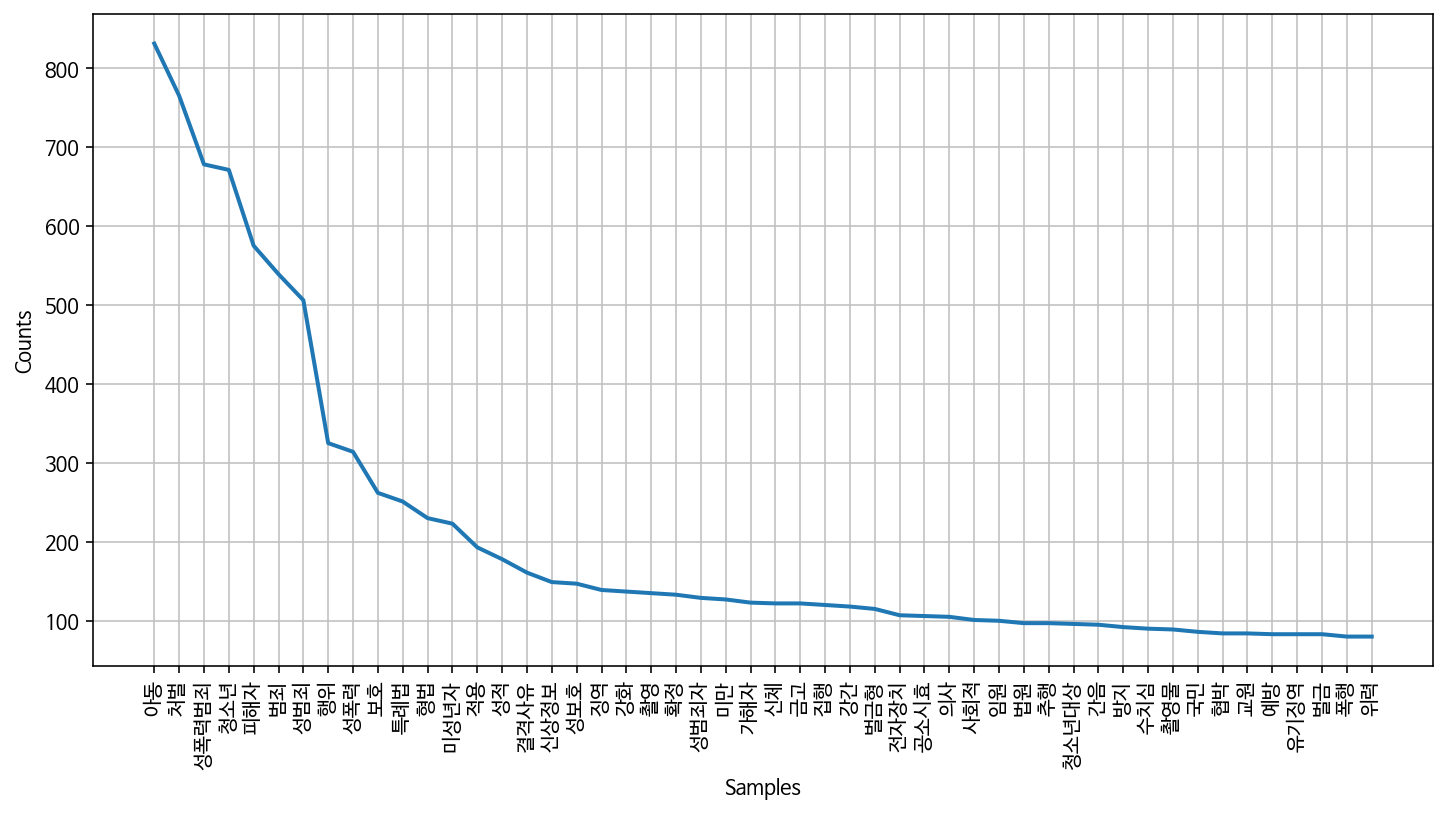

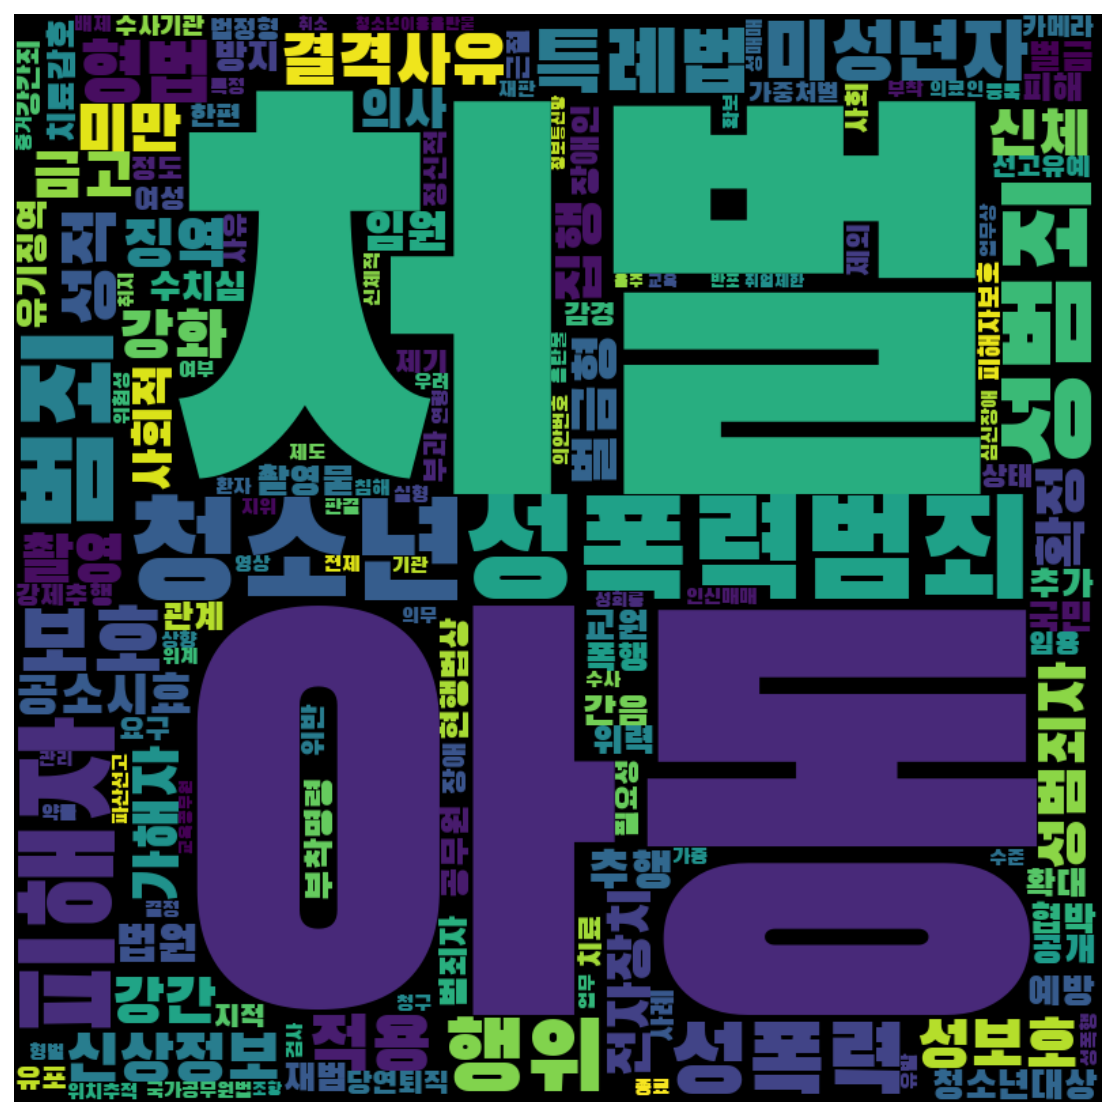

In [102]:
frewords_vis(men_g3_tokens)
wordcloud_vis(men_g3_tokens)

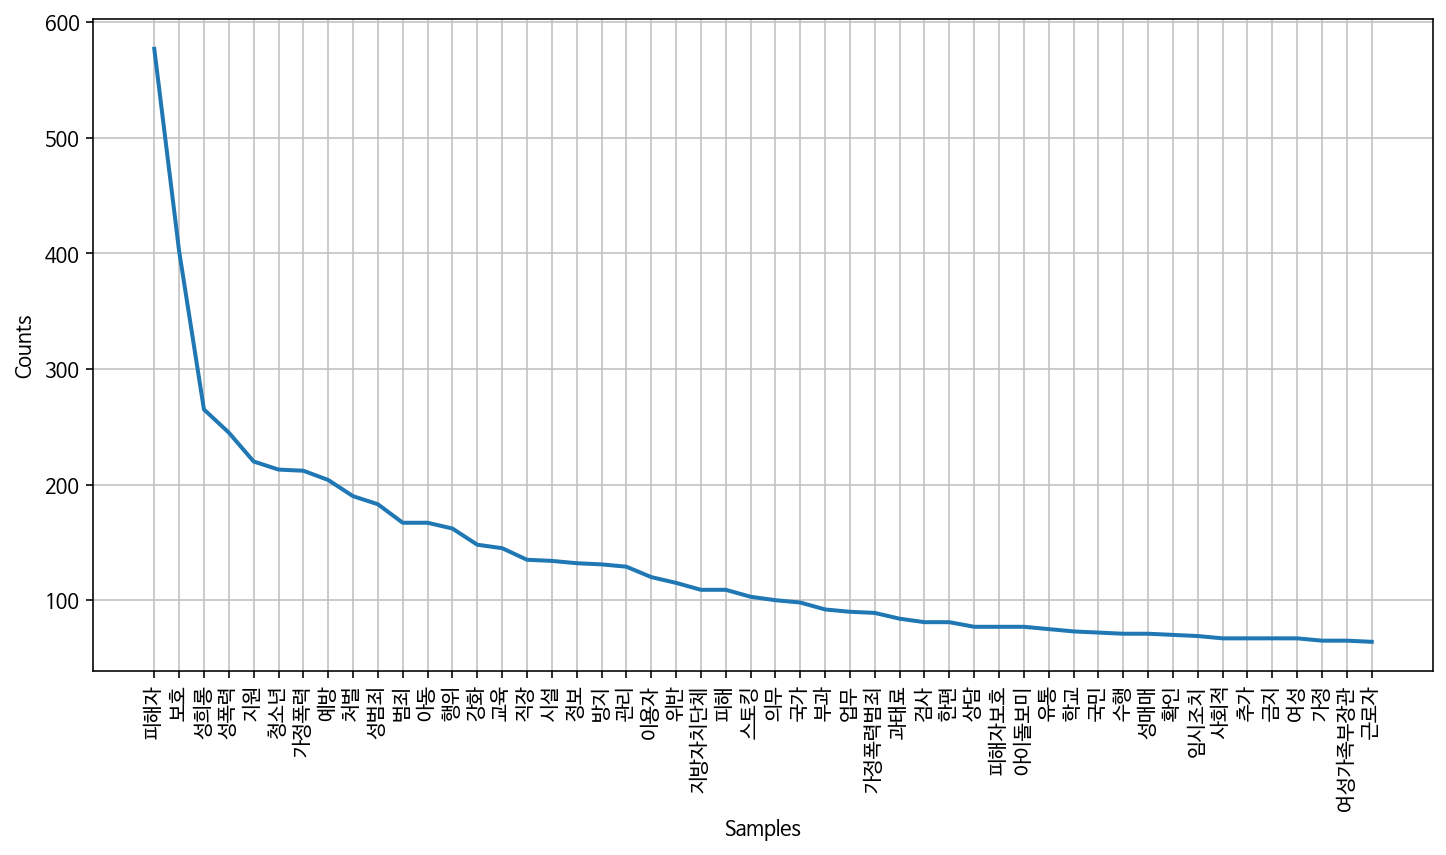

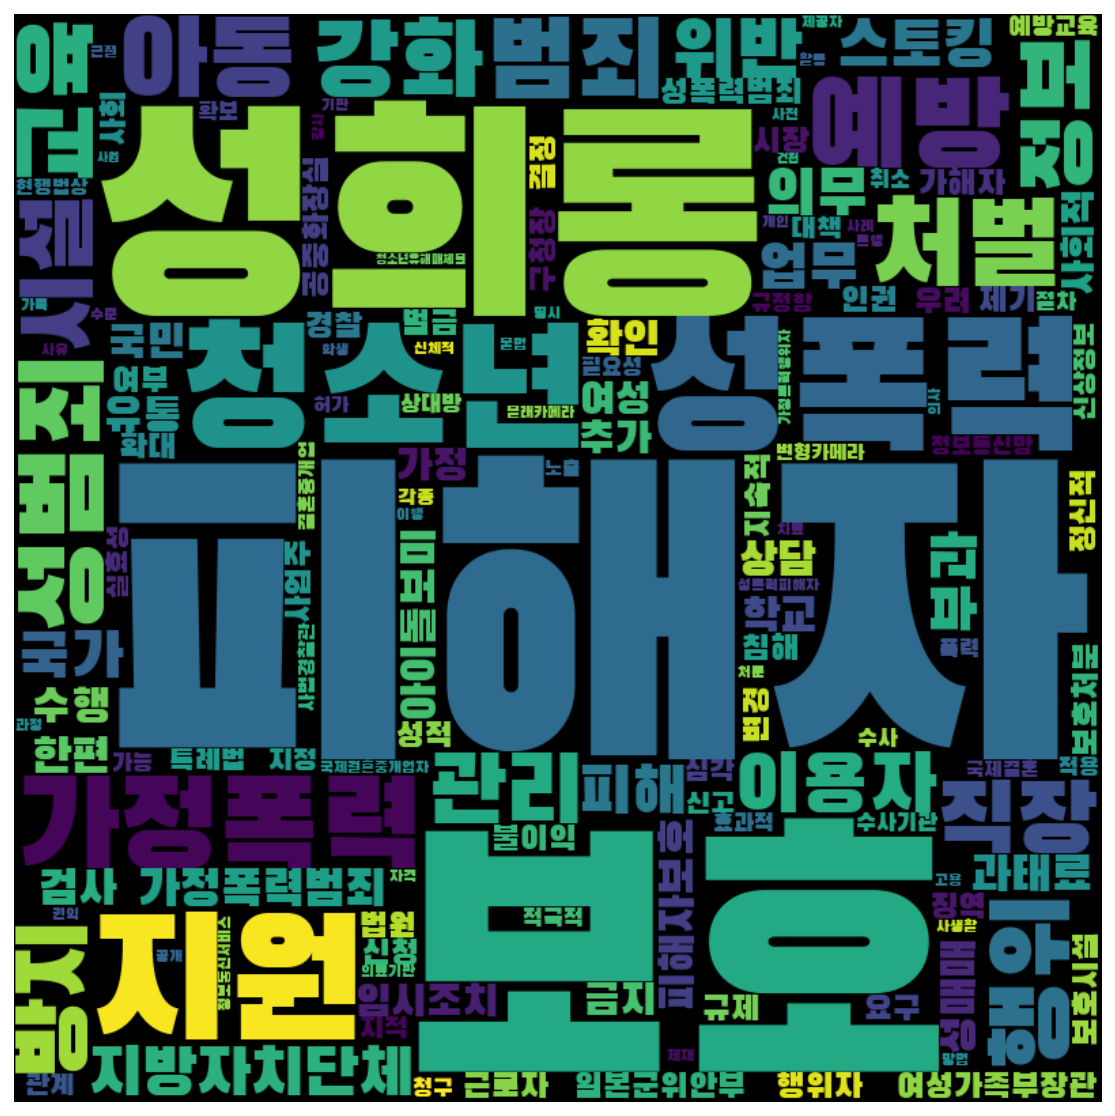

In [103]:
frewords_vis(men_g4_tokens)
wordcloud_vis(men_g4_tokens)

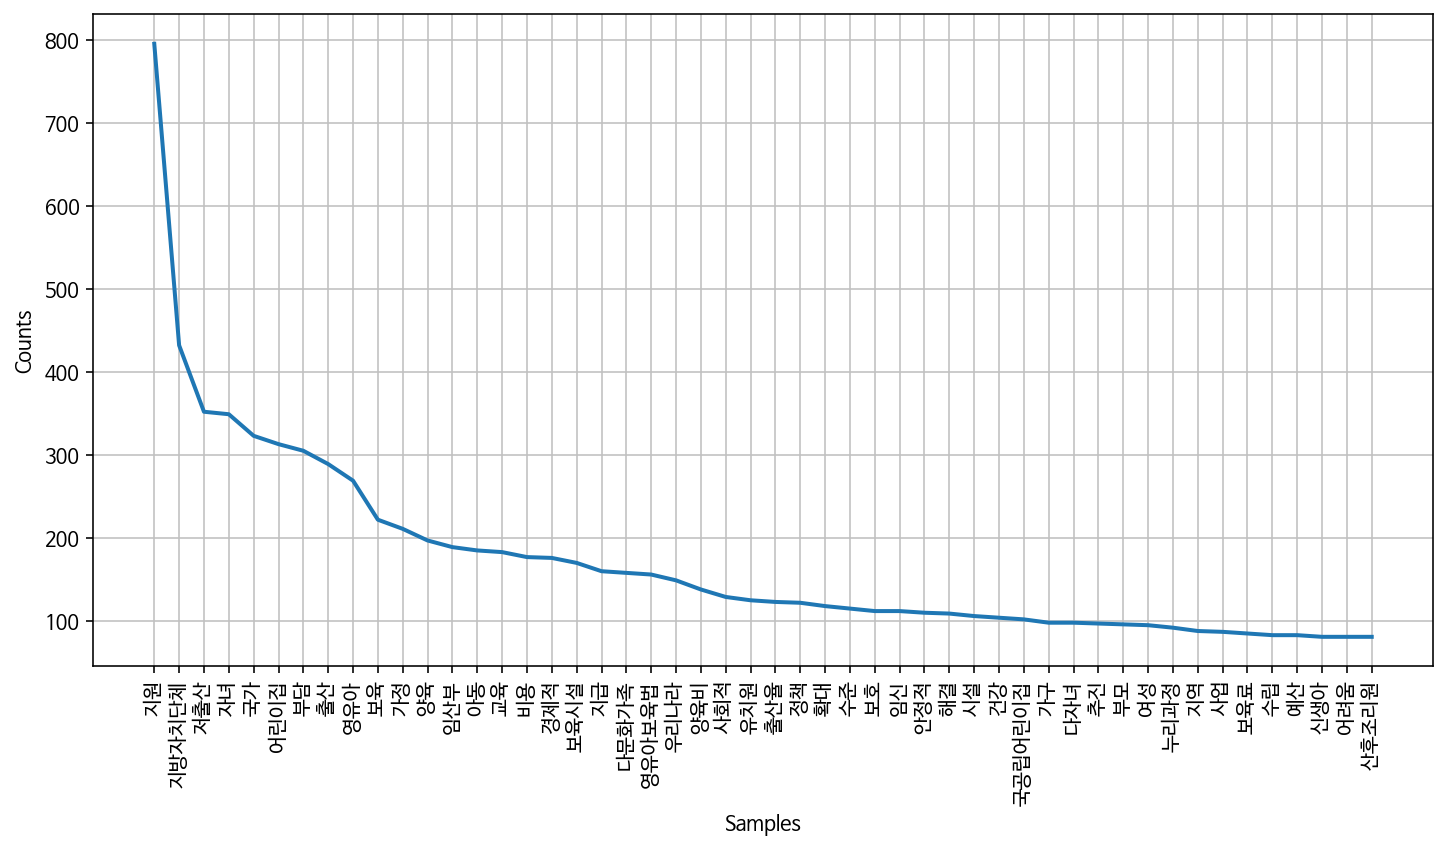

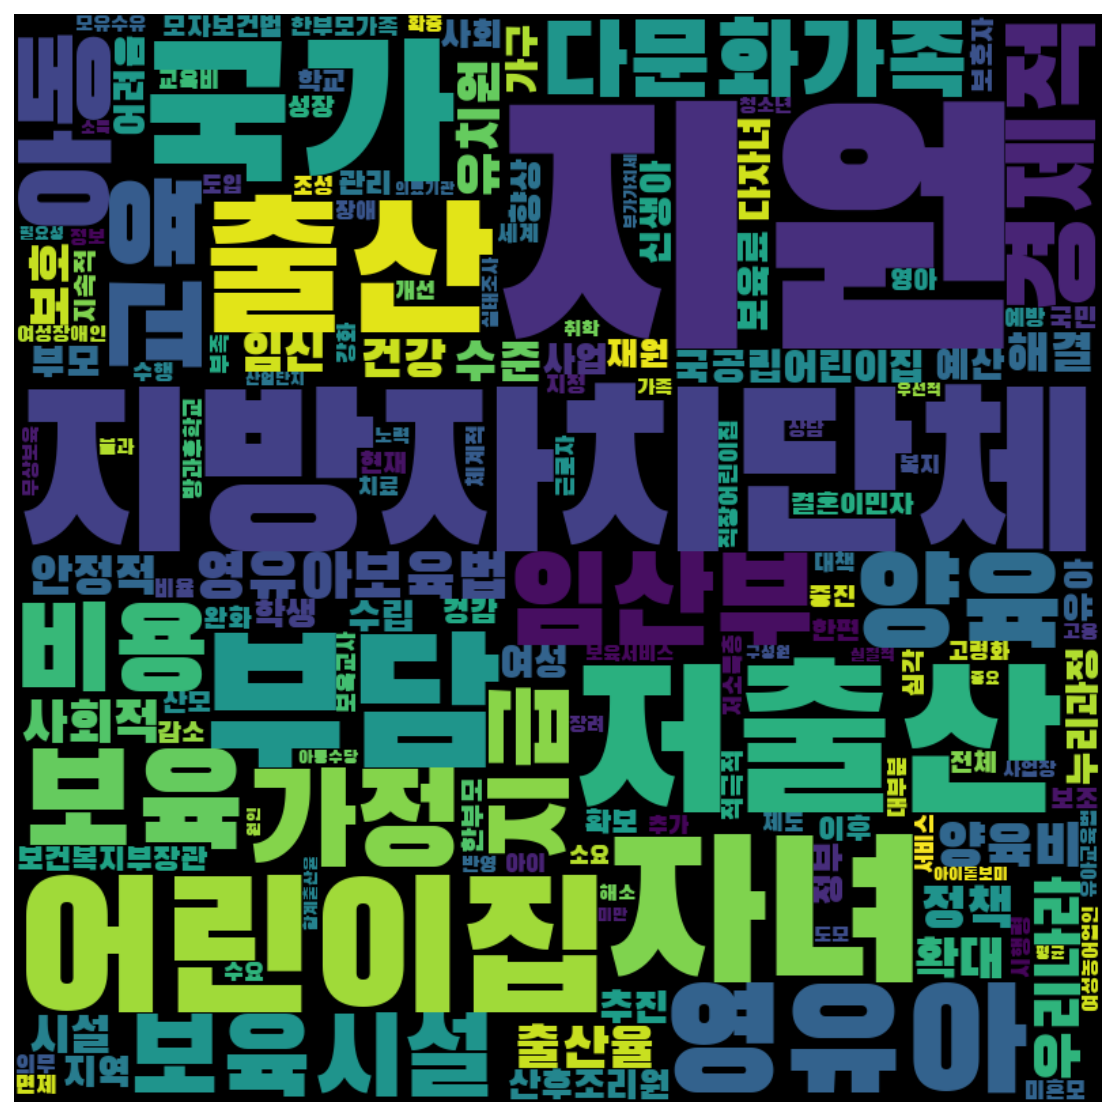

In [104]:
frewords_vis(men_g5_tokens)
wordcloud_vis(men_g5_tokens)

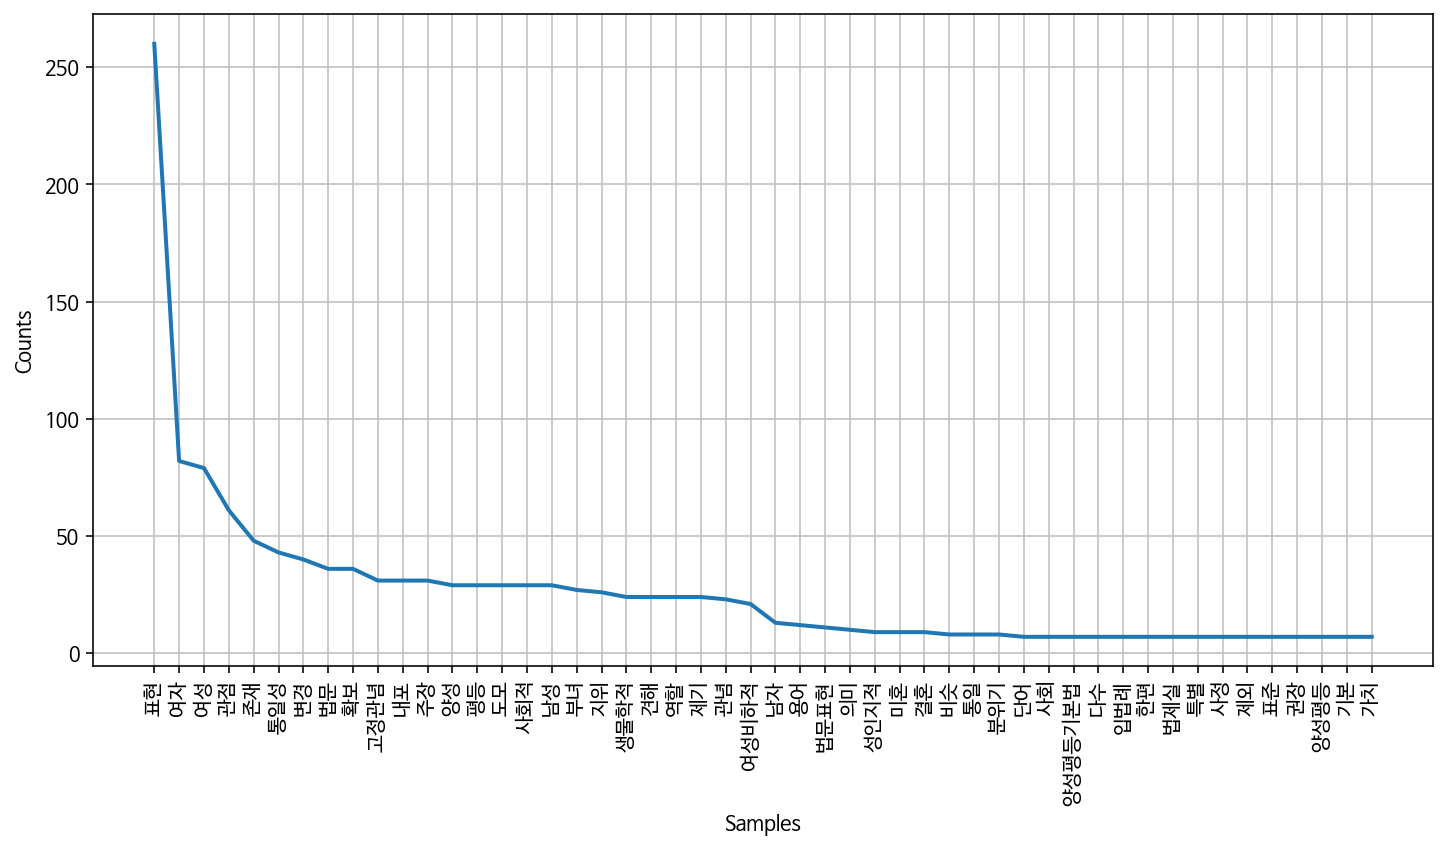

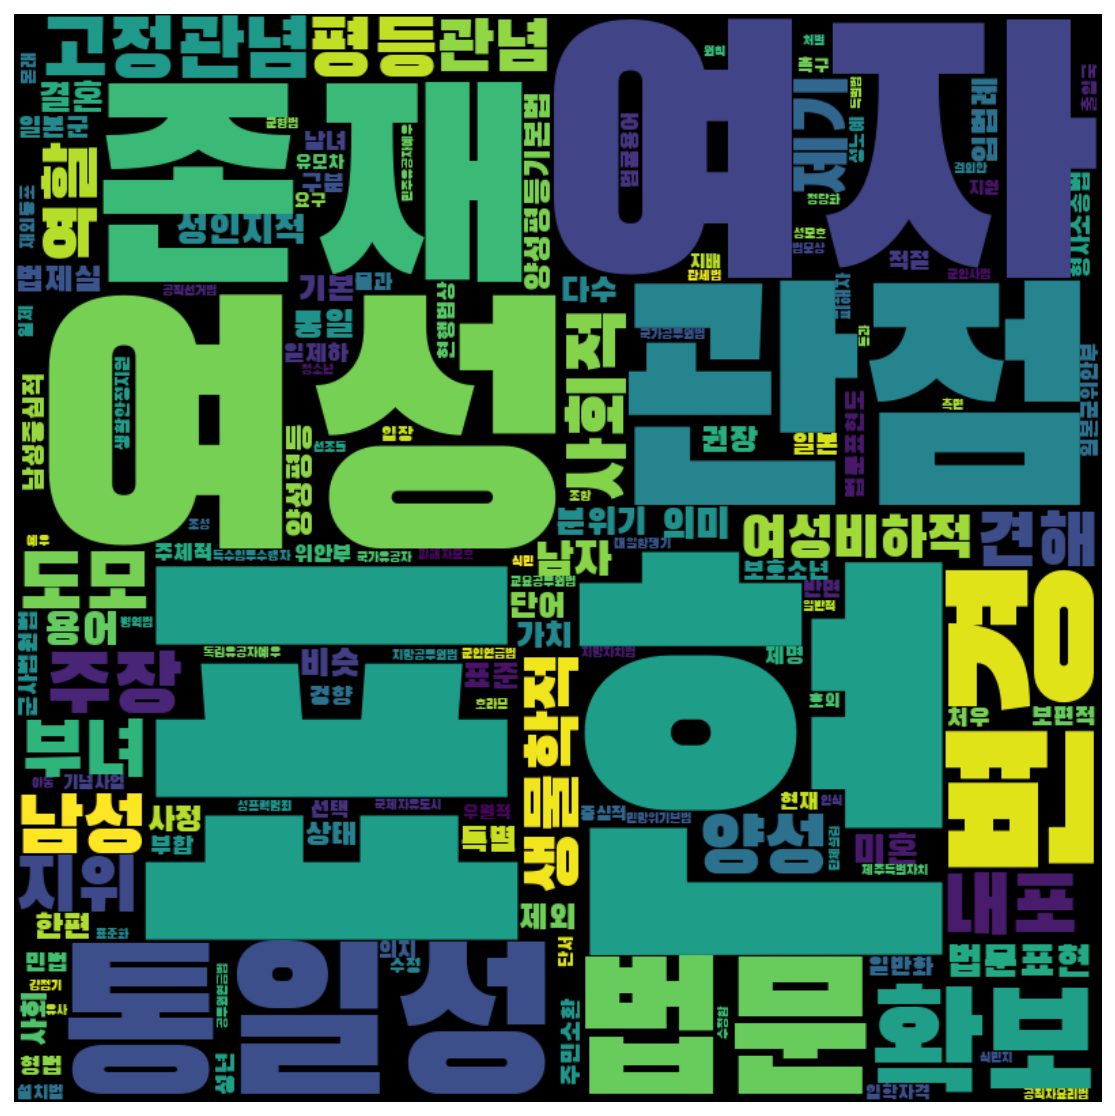

In [105]:
frewords_vis(men_g6_tokens)
wordcloud_vis(men_g6_tokens)